### Step One: Select stocks


In [1]:
# import Libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
np.random.seed(1) #to fix the results

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime

import yfinance as yf
yf.pdr_override()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.cluster import KMeans
from sklearn import cluster

%matplotlib inline
import math
import arch
import talib as ta
from arch import arch_model
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pmdarima as pm
import statsmodels.stats as sms
import scipy as sp
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.tsa.vector_ar.vecm as vm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from statsmodels.stats.diagnostic import het_arch
import datetime as dt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.neural_network import MLPRegressor


import matplotlib.pyplot as plt
np.random.seed(1) #to fix the results

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime

import yfinance as yf
yf.pdr_override()


import scipy as sp
from statsmodels.stats.diagnostic import het_arch
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand

#### Choose Stocks based on Greenblatt's Screener

To initiate my stock selection process, I utilize Greenblatt’s screener to identify 50 stocks with a minimum Market Cap of $50 million. However, pinpointing stocks with promising potential, especially in terms of Cash-flow from operations, demands an in-depth analysis of companies' financial databases, which can be time-consuming. As an alternative, I employ https://www.magicformulainvesting.com/ for a more efficient approach. This platform ranks stocks based on two key factors:

1. Profitability: Evaluated using Greenblatt’s preferred metric, "Return on Capital".
2. Earnings Yield: Calculated as the inverse of the P/E ratio, defined by Greenblatt as EBIT / Enterprise Value.

By leveraging these criteria, I aim to identify fundamentally sound, relatively small, and cost-effective stocks with strong potential for investment.

##### Calculate the average piotroski score for each stock
To filter stocks effectively, I rely on three robust scoring systems: Piotroski for growth potential assessment, Altman for bankruptcy risk evaluation, and Beneish for detecting potential accounting fraud.

For calculating the Piotroski Score, I extract financial ratio data of the 50 selected stocks from the WRDS website spanning from January 31, 2019, to December 31, 2023. Using the Piotroski_Parser_CDS code, I compute the Piotroski score based on nine key criteria:

1. Return on Assets
2. Cash Flow from Operations
3. Increase in Return on Assets
4. Cash Flow exceeding Return on Assets
5. Long-Term Debt to Asset Ratio
6. Increase in Liquidity
7. Dilution
8. Gross Margin
9. Asset Turnover

The Piotroski score employs a nine-point fundamental scoring system (F-Score), where each criterion carries a binary value. A higher score indicates a stronger company performance, with a maximum achievable score of 9. Generally, a Piotroski Score ranging from 7 to 9 is considered good, while a score between 0 and 2 is deemed weak. Finally, for each stock, the average of piotroski score is claculated. 

In [2]:
dffac = pd.read_csv('50stockdata_WSD.csv')
dffac = dffac.fillna(0)
dffac['datetime'] = pd.to_datetime(dffac['public_date'])
dffac.drop(['adate', 'qdate'], axis=1, inplace=True)
dffac.sort_values(by=["permno","datetime"], inplace=True)
dffac.tail(5)

,gvkey,permno,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,...,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER,cusip,datetime
2679,184256,93264,2023-08-31,15.535,0.342,8.709,-88.000,-44.000,-1.464,-1.464,...,2.715,0.0,0.0,-1.211,2.105,0.0,0,IRWD,46333X10,2023-08-31
2680,184256,93264,2023-09-30,17.011,0.342,8.709,-96.300,-48.150,-1.602,-1.602,...,2.715,0.0,0.0,-1.211,2.305,0.0,0,IRWD,46333X10,2023-09-30
2681,184256,93264,2023-10-31,15.846,0.342,8.709,-89.700,-44.850,-1.493,-1.493,...,2.715,0.0,0.0,-1.211,2.147,0.0,0,IRWD,46333X10,2023-10-31
2682,184256,93264,2023-11-30,30.735,0.342,9.698,-34.138,-29.118,-1.602,-1.602,...,2.732,0.0,0.0,-1.333,2.369,0.0,0,IRWD,46333X10,2023-11-30
2683,184256,93264,2023-12-31,35.516,0.342,9.698,0.000,0.000,0.000,0.000,...,2.732,0.0,0.0,-1.333,2.738,0.0,0,IRWD,46333X10,2023-12-31


In [3]:
# Piotroski_Parser_CDS code

dffac['cofra'] = dffac.ocf_lct*dffac.curr_debt*dffac.lt_ppent
n = 12
dffac['roe_delta'] = np.where(dffac.permno == dffac.permno.shift(n), (dffac.roe-dffac.roe.shift(n)), dffac.roe)
dffac['roa_delta'] = np.where(dffac.permno == dffac.permno.shift(n), (dffac.roa-dffac.roa.shift(n)), dffac.roa)
dffac['debt_assets_delta']= np.where(dffac.permno == dffac.permno.shift(n), (dffac.debt_assets-dffac.debt_assets.shift(n)), dffac.debt_assets)
dffac['debt_invcap_delta']= np.where(dffac.permno == dffac.permno.shift(n), (dffac.debt_invcap-dffac.debt_invcap.shift(n)), dffac.debt_invcap)
dffac['de_ratio_delta']=np.where(dffac.permno == dffac.permno.shift(n), (dffac.de_ratio-dffac.de_ratio.shift(n)), dffac.de_ratio)
dffac['dltt_be_delta']=np.where(dffac.permno == dffac.permno.shift(n), (dffac.dltt_be-dffac.dltt_be.shift(n)), dffac.dltt_be)
dffac['curr_ratio_delta']=np.where(dffac.permno == dffac.permno.shift(n), (dffac.curr_ratio-dffac.curr_ratio.shift(n)), dffac.curr_ratio)
dffac['gpm_delta']=np.where(dffac.permno == dffac.permno.shift(n), (dffac.gpm-dffac.gpm.shift(n)), dffac.gpm)
dffac['at_turn_delta']=np.where(dffac.permno == dffac.permno.shift(n), (dffac.at_turn-dffac.at_turn.shift(n)), dffac.at_turn)

dffac['piotroski_roa_delta'] = np.where(dffac.roa_delta>0,1,0) #1 Stands for positive net income
dffac['piotroski_roa'] = np.where(dffac.roa>0,1,0) #2 Positive return on assets in the current year
dffac['piotroski_cofra'] = np.where(dffac.cofra>0,1,0) #3 Positive operating cash flow in the current year
dffac['piotroski_cofra>roa']=np.where(dffac.cofra>dffac.roa,1, 0) #4 Cash flow from operations being greater than net Income
dffac['piotroski_debt_invcap_delta'] = np.where(dffac.debt_invcap_delta<0,1,0) #5 Lower ratio of long term debt in the current period, compared to the previous year 
dffac['piotroski_debt_assets_delta'] = np.where(dffac.debt_assets_delta<0,1,0) #5 Lower ratio of long term debt in the current period, compared to the previous year (second version)
dffac['piotroski_curr_ratio_delta'] = np.where(dffac.curr_ratio_delta>0,1,0) #6 Higher current ratio this year compared to the previous year
dffac['piotroski_de_ratio_delta'] = np.where(dffac.de_ratio_delta>=0,1,0)  #7  no new shares were issued in the last year
dffac['piotroski_dltt_be_delta'] = np.where(dffac.dltt_be_delta>=0,1,0)  #7  no new shares were issued in the last year (second version)
dffac['piotroski_gpm_delta'] = np.where(dffac.gpm_delta>0,1,0)  #8 A higher gross margin compared to the previous year
dffac['piotroski_at_turn_delta'] = np.where(dffac.at_turn_delta>0,1,0)  #9 A higher asset turnover ratio compared to the previous year
dffac['piotroski'] = dffac['piotroski_roa_delta']+dffac['piotroski_roa']+dffac['piotroski_cofra']\
        +dffac['piotroski_cofra>roa']+dffac['piotroski_debt_assets_delta']+dffac['piotroski_debt_invcap_delta']\
        +dffac['piotroski_curr_ratio_delta']+dffac['piotroski_de_ratio_delta']+dffac['piotroski_dltt_be_delta']\
        +dffac['piotroski_gpm_delta']+dffac['piotroski_at_turn_delta'] 
dffac.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
#dffac.to_csv("piotroski_factors_cds.csv") 
df =  dffac[['public_date', 'TICKER', 'piotroski']]
df.to_csv("piotroski_stock_CDS.csv")

In [4]:
dataframe = pd.read_csv("piotroski_stock_CDS.csv")
dataframe["public_date"] = pd.to_datetime(dataframe["public_date"], format='%Y/%m/%d')
dataframe["year"] = dataframe["public_date"].dt.year
dataframe.tail(5)

,Unnamed: 0,public_date,TICKER,piotroski,year
2679,2679,2023-08-31,IRWD,9,2023
2680,2680,2023-09-30,IRWD,9,2023
2681,2681,2023-10-31,IRWD,9,2023
2682,2682,2023-11-30,IRWD,7,2023
2683,2683,2023-12-31,IRWD,7,2023


In [5]:
dataframe = dataframe.fillna(0)

piotroski_means = dataframe.groupby('TICKER')['piotroski'].mean()
piotroski_means.head(5)

TICKER
0       5.600000
AMCX    6.650000
AMLX    4.700000
AMN     7.100000
ASRT    7.316667
Name: piotroski, dtype: float64

#### Calculate the average  Beneish M for each stock

To calculate the Beneish M score, I visit http://www.gurufocus.com/ and retrieve the BENEISH M-SCORE for each stock. This score is optimized to detect earnings manipulation rather than bankruptcy and is based on eight different indices:

1. DSRI (Days’ Sales in Receivables Index)
2. GMI (Gross Margin Index)
3. AQI (Asset Quality Index)
4. SGI (Sales Growth Index)
5. DEPI (Depreciation Index)
6. SGAI (Sales, General, and Administrative expenses Index)
7. LVGI (Leverage Index)
8. TATA (Total Accruals to Total Assets)

The Beneish M Score formula integrates these variables with specific weights assigned as follows:

M = -4.84 + 0.92*DSRI + 0.528*GMI + 0.404*AQI + 0.892*SGI + 0.115*DEPI – 0.172*SGAI + 4.679*TATA – 0.327*LVGI

A score greater than -1.78 indicates a strong likelihood of a firm being involved in earnings manipulation.

In [6]:
stock = pd.read_excel("BENEISH M-SCORE.xlsx")
stock.head(5)

,Unnamed: 0,2019,2020,2021,2022,2023
0,MO,-3.06,-2.72,-3.11,34.07,-3.35
1,AMCX,-2.44,-2.88,-2.27,-2.31,-2.39
2,AMN,-2.75,-2.79,-1.60,-2.79,-2.92
3,AMLX,NaN,NaN,NaN,NaN,23.00
4,ASRT,-3.58,-1.57,-2.42,-1.64,-4.78


In [7]:
# fill the nan with zero
stock = stock.fillna(0)
stock["BENEISH_M_SCORE_means"] = stock.iloc[: ,1:5].mean(axis=1)
stock.head(5)

,Unnamed: 0,2019,2020,2021,2022,2023,BENEISH_M_SCORE_means
0,MO,-3.06,-2.72,-3.11,34.07,-3.35,6.2950
1,AMCX,-2.44,-2.88,-2.27,-2.31,-2.39,-2.4750
2,AMN,-2.75,-2.79,-1.60,-2.79,-2.92,-2.4825
3,AMLX,0.00,0.00,0.00,0.00,23.00,0.0000
4,ASRT,-3.58,-1.57,-2.42,-1.64,-4.78,-2.3025


In [8]:
stock = stock.rename(columns={"Unnamed: 0": "Ticker"})
stock = stock.set_index("Ticker")
BENEISH_M_SCORE_means = stock["BENEISH_M_SCORE_means"]

#### Calculate the average of Altman Z score 

To gauge the likelihood of impending bankruptcy, investors employ the Altman Z-score model, which condenses five crucial performance ratios into a single score. The Z-score offers a comprehensive snapshot of corporate financial health. The formula for the Z-score is as follows:

Z-score = 1.2A + 1.4B + 3.3C + 0.6D + 1E

Where:
- A = Working Capital/Total Assets
- B = Retained Earnings/Total Assets
- C = Earnings Before Interest and Tax/Total Assets
- D = Market Value of Equity/Total Liabilities
- E = Sales/Total Assets

A lower Z-score indicates higher odds of a company facing bankruptcy. Particularly, a Z-score lower than 1.8 suggests that the company is on the verge of bankruptcy. On the other hand, companies with scores above 3 are unlikely to face bankruptcy. Scores falling between 1.8 and 3 fall into a grey area, warranting closer scrutiny.

Quarterly financial data from stocks spanning from January 1, 2019, to December 31, 2023, is extracted from WRDS. Utilizing the Altman_Parser_CDS Python code, the Altman Z-score is computed for each stock based on this data. Subsequently, the average Altman score for each stock is determined.

In [9]:
#### Altman_Parser_CDS Python code

dffac = pd.read_csv('altmanstockWSD.csv')
#dffac = dffac.iloc[:105,:]
dffac['datadate'] = pd.to_datetime(dffac['datadate'])
dffac.sort_values(by=["gvkey","datadate"], inplace=True)
dffac = dffac.drop_duplicates()

#how many gvkeys have we got?
dfgvkey = pd.DataFrame(dffac.gvkey) 
dfgvkey = dfgvkey.drop_duplicates()
dfgvkey.sort_values(by=["gvkey"], inplace=True) 
dfgvkey = pd.DataFrame(dfgvkey.values, columns=["gvkey"]) #reindex didnt work
#dfgvkey.to_csv("allcap_dfgvkeys_with_wrds_data.csv") 

#how many dates have we got?
dfdate = pd.DataFrame(dffac.datadate)
dfdate = dfdate.drop_duplicates()
dfdate.sort_values(by=["datadate"], inplace=True) 
dfdate = pd.DataFrame(dfdate.values, columns=["datadate"]) #reindex didnt work


dffac['A'] = dffac.wcapq/dffac.atq 
 
dffac['B'] = dffac.req/dffac.atq
dffac['C'] = dffac.oibdpq/dffac.atq
dffac['D'] = dffac.mkvaltq/dffac.ltq 
dffac['D'] = dffac.cshoq*dffac.prccq/dffac.ltq
dffac['E'] = dffac.saleq/dffac.atq

dffac['AltmanZScore'] = 1.2*dffac.A + 1.4*dffac.B + 3.3*dffac.C + 0.6*dffac.D + 1.0*dffac.E 
dffac.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
#dffac.to_csv("altman_factors_CDS.csv") 
df =  dffac[['datadate', 'tic', 'AltmanZScore']]
df.to_csv("Altman_factors_CDS.csv")

In [10]:
df = df.fillna(0)

AltmanZScore_means = df.groupby('tic')['AltmanZScore'].mean()
AltmanZScore_means.head(5)

tic
AMCX     1.121385
AMLX    17.797637
AMN      2.313812
ASRT    -0.899720
BBW      1.465027
Name: AltmanZScore, dtype: float64

In [11]:
data = pd.concat([AltmanZScore_means, piotroski_means, BENEISH_M_SCORE_means], axis=1, keys=['AltmanZScore', 'Piotroski', 'BENEISH_M_SCORE_means'])
data = data.drop(["UNTC","0","CECO","HYAC"])
len(data)

49

#### Calculate the  return and violitilityof stocks

I import the stock price data for each stock. Due to stocks with more than 30% null values, they are excluded from analysis. Missing values in the remaining dataset are filled with the last available value. Subsequently, I calculate the annual percentage return of the close price and volatility for each stock. Finally, I compile a dataframe containing 44 stocks along with their Piotroski scores, Altman Z-scores, Beneish M scores, annual returns, and annual volatility.

In [12]:
start_date=datetime.datetime(2019, 1, 1)
end_date=datetime.datetime(2023, 12, 31)

stock_list = ["MO", "AMCX","AMN","AMLX","ASRT","BTMD","BKE","BBW","CPRX","COLL","CCSI","CROX","CVS","EVRI",
              "GTX","HRB", "HRMY", "HSII","HPQ","IMMR","IDCC","IPG","IRWD","JILL","JAKK","LNTH","LTRPA","MPX",
              "MCFT","MED","MLI","NATH","MD","PRDO","PLTK","PINC","PBYI","RCMT","RMNI","SCYX","SPRO","SURG",
              "TPR","TH","TZOO","UIS","UNTC","VGR","WNC","ZYME" ]
stock_str = ""
for i in range(len(stock_list)):
    stock_str  = stock_str + stock_list[i] + "."

main_df = pd.DataFrame()

for stock in stock_list:
    df = pdr.get_data_yahoo(stock, start=start_date, end=end_date)
    df['Ticker'] = stock  # Add a new column 'Ticker' with the stock name
    main_df = pd.concat([main_df, df], axis=0)

# Reset index
main_df.reset_index(inplace=True) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [13]:
main_df.to_csv("main_df.csv")
pivot_df = main_df.pivot(index='Ticker', columns='Date', values='Close')
pivot_df.to_csv("pivot_df.csv")
print ("Null Values =",pivot_df.isnull().values.any())

Null Values = True


In [14]:
missing_fractions = pivot_df.isnull().mean(axis=1).sort_values(ascending=False)
drop_list = missing_fractions[missing_fractions.values > 0.3].index
drop_list

Index(['AMLX', 'CCSI', 'BTMD', 'PLTK', 'UNTC'], dtype='object', name='Ticker')

In [15]:
pivot_df.drop(labels = drop_list, axis =0, inplace = True)
pivot_df.shape

(44, 1258)

In [16]:
# fil the missing values with the last value available in the dataset
pivot_df = pivot_df.fillna(method = "ffill")

In [17]:
ind = pivot_df.index
ind

Index(['AMCX', 'AMN', 'ASRT', 'BBW', 'BKE', 'COLL', 'CPRX', 'CROX', 'CVS',
       'EVRI', 'GTX', 'HPQ', 'HRB', 'HSII', 'IDCC', 'IMMR', 'IPG', 'IRWD',
       'JAKK', 'JILL', 'LNTH', 'LTRPA', 'MCFT', 'MD', 'MED', 'MLI', 'MO',
       'MPX', 'NATH', 'PBYI', 'PINC', 'PRDO', 'RCMT', 'RMNI', 'SCYX', 'SPRO',
       'SURG', 'TH', 'TPR', 'TZOO', 'UIS', 'VGR', 'WNC', 'ZYME'],
      dtype='object', name='Ticker')

In [18]:
index = []
returns = []
volatility = []
for i in pivot_df.index:
    index.append(i)
    ret_mean = pivot_df.loc[i,:].pct_change().mean()*252
    vol = pivot_df.loc[i,:].pct_change().std()*np.sqrt(252)
    returns.append(ret_mean)
    volatility.append(vol)
    
data_price_risk = pd.DataFrame({'returns': returns,"volatility":volatility}, index=index)
data_price_risk.shape

(44, 2)

In [19]:
data_price_risk.head(3)

,returns,volatility
AMCX,-0.047129,0.595383
AMN,0.153574,0.431495
ASRT,-0.013115,1.013705


In [20]:
data.shape

(49, 3)

In [21]:
joined_df = pd.concat([data_price_risk, data], axis=1)


In [22]:
joined_df = joined_df.drop(["AMLX","BTMD","CCSI","HRMY","PLTK"])

In [23]:
# scale  the dataframe before applying clustering 

scaler = StandardScaler().fit(joined_df)
rescaledDataset = pd.DataFrame(scaler.fit_transform(joined_df), columns =joined_df.columns, index = joined_df.index)
rescaledDataset.head(10)

,returns,volatility,AltmanZScore,Piotroski,BENEISH_M_SCORE_means
AMCX,-1.278717,-0.047308,-0.198760,-0.415259,-0.168991
AMN,-0.274345,-0.759447,0.152356,0.128917,-0.169166
ASRT,-1.108503,1.770425,-0.793885,0.390928,-0.164985
BBW,2.107922,0.756897,-0.097573,-0.213712,-0.176133
BKE,0.455119,-0.497650,0.423943,0.390928,-0.154882
COLL,0.213018,-0.304830,-0.394304,0.451392,-0.165101
CPRX,2.166473,0.227132,3.820529,-0.294331,6.551521
CROX,1.120262,0.030506,0.432529,0.370773,-0.146927
CVS,-0.656580,-1.408679,-0.218896,0.229691,-0.169746
EVRI,1.163778,0.502600,-0.332211,0.794021,-0.169804


In [24]:
rescaledDataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, AMCX to ZYME
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   returns                44 non-null     float64
 1   volatility             44 non-null     float64
 2   AltmanZScore           44 non-null     float64
 3   Piotroski              44 non-null     float64
 4   BENEISH_M_SCORE_means  44 non-null     float64
dtypes: float64(5)
memory usage: 2.1+ KB


#### Clustring 
For clustering, I employed the k-means clustering algorithm, an unsupervised machine learning method that groups data points based on similarities. To determine the optimal number of clusters (k), I utilized the elbow method, which indicated that k = 4 is the most suitable choice. After applying k-means clustering with 4 clusters, I calculated the mean of features for each cluster.

However, upon analyzing the data, it appears that there is an outlier, represented by the CPRX stock. To refine the clustering process, I removed the CPRX stock and repeated the elbow method. This time, the elbow method suggests k = 6 as the optimal number of clusters. I performed clustering with k = 6 and observed that cluster 1 exhibits characteristics that make it a good choice. It displays the lowest volatility, with an average Piotroski score of 7.61, an average Altman score of 8.2, and an average Beneish M-score of -2.42.

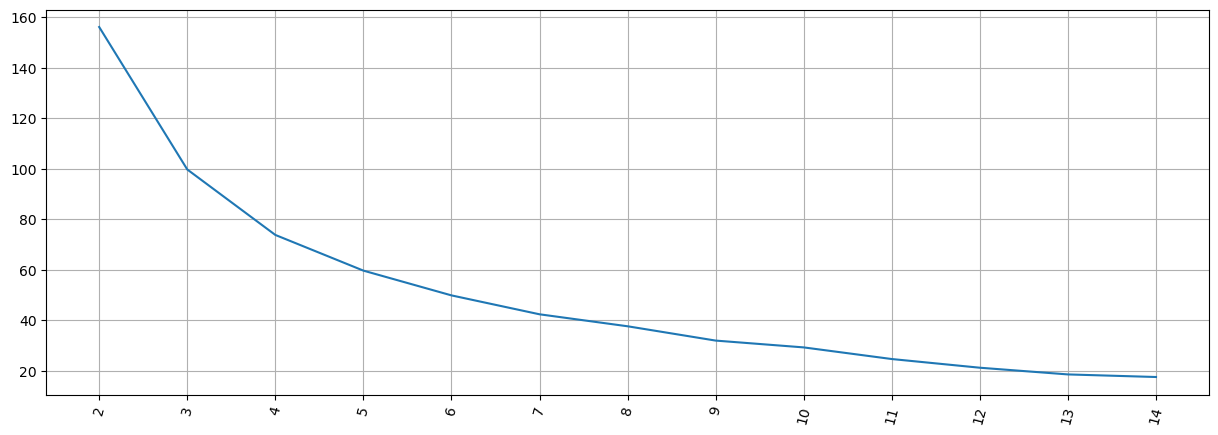

In [25]:
# find the best K

distortions = []
max_loops = 15
for k in range (2,max_loops):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(rescaledDataset)
    distortions.append(kmeans.inertia_)
    
fig = plt.figure(figsize = (15,5))
plt.plot(range(2,max_loops),distortions)
plt.xticks([i for i in range(2,max_loops)],rotation =75)
plt.grid(True)

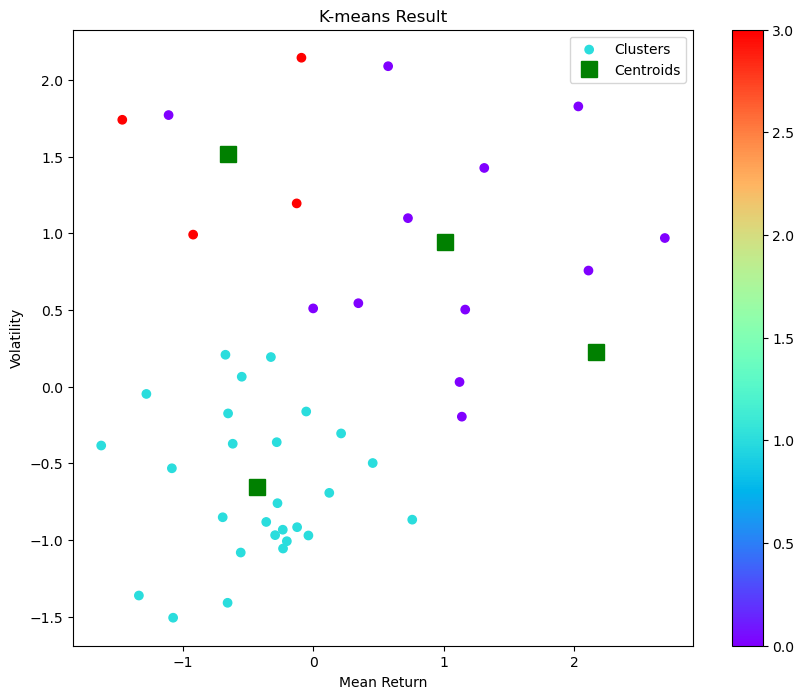

In [26]:
nclust = 4
k_means = cluster.KMeans(n_clusters = nclust)
k_means.fit(rescaledDataset)


# Visualizing how clusters are formed
centroids = k_means.cluster_centers_

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

scatter = ax.scatter(rescaledDataset.iloc[:, 0], rescaledDataset.iloc[:, 1], c=k_means.labels_,
                     cmap="rainbow", label="Clusters")  # Use k_means.labels_ for cluster labels
ax.set_title("K-means Result")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")

# Add colorbar
plt.colorbar(scatter)

# Plot centroids
plt.plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=11, label='Centroids')

plt.legend()
plt.show()

In [27]:
data_stock = joined_df.copy()
data_stock["cluster"] = k_means.labels_
data_stock.groupby('cluster').mean()

,returns,volatility,AltmanZScore,Piotroski,BENEISH_M_SCORE_means
cluster,,,,,
0,0.409839,0.823526,1.064116,6.968013,-2.205000
1,0.122089,0.456040,2.304861,7.292778,-1.720463
2,0.641320,0.658540,14.771309,6.750000,286.885000
3,0.078409,0.955484,-2.682629,5.109534,-0.680625


In [28]:
data_stock["cluster"].value_counts()

1    27
0    12
3     4
2     1
Name: cluster, dtype: int64

In [29]:
data_stock

,returns,volatility,AltmanZScore,Piotroski,BENEISH_M_SCORE_means,cluster
AMCX,-0.047129,0.595383,1.121385,6.650000,-2.4750,1
AMN,0.153574,0.431495,2.313812,7.100000,-2.4825,1
ASRT,-0.013115,1.013705,-0.899720,7.316667,-2.3025,0
BBW,0.629620,0.780457,1.465027,6.816667,-2.7825,0
BKE,0.299342,0.491743,3.236151,7.316667,-1.8675,1
COLL,0.250963,0.536118,0.457299,7.366667,-2.3075,1
CPRX,0.641320,0.658540,14.771309,6.750000,286.8850,2
CROX,0.432257,0.613290,3.265308,7.300000,-1.5250,0
CVS,0.077192,0.282084,1.053003,7.183333,-2.5075,1
EVRI,0.440953,0.721935,0.668172,7.650000,-2.5100,0


In [30]:
data_final = joined_df.drop(["CPRX"],axis=0)

In [31]:
rescaledDataset1 = pd.DataFrame(scaler.fit_transform(data_final), columns =data_final.columns, index = data_final.index)
rescaledDataset1.head(3)

,returns,volatility,AltmanZScore,Piotroski,BENEISH_M_SCORE_means
AMCX,-1.286539,-0.041570,-0.133689,-0.417700,-0.387079
AMN,-0.234575,-0.745994,0.293388,0.120799,-0.391134
ASRT,-1.108260,1.756467,-0.857565,0.380076,-0.293830


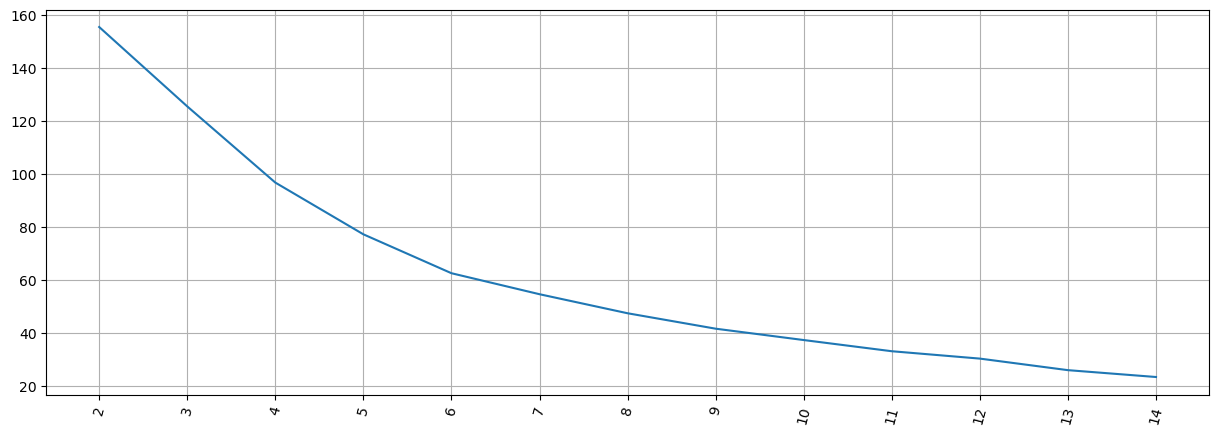

In [32]:
# find the best K

distortions = []
max_loops = 15
for k in range (2,max_loops):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(rescaledDataset1)
    distortions.append(kmeans.inertia_)
    
fig = plt.figure(figsize = (15,5))
plt.plot(range(2,max_loops),distortions)
plt.xticks([i for i in range(2,max_loops)],rotation =75)
plt.grid(True)

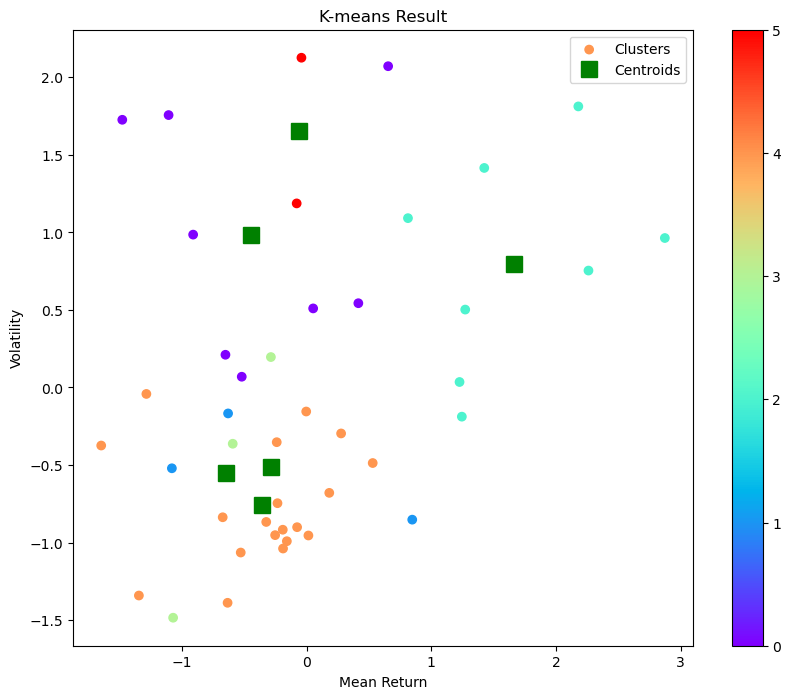

In [33]:
nclust = 6
k_means = cluster.KMeans(n_clusters = nclust)
k_means.fit(rescaledDataset1)


# Visualizing how clusters are formed
centroids = k_means.cluster_centers_

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

scatter = ax.scatter(rescaledDataset1.iloc[:, 0], rescaledDataset1.iloc[:, 1], c=k_means.labels_,
                     cmap="rainbow", label="Clusters")  # Use k_means.labels_ for cluster labels
ax.set_title("K-means Result")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")

# Add colorbar
plt.colorbar(scatter)

# Plot centroids
plt.plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=11, label='Centroids')

plt.legend()
plt.show()

In [34]:
data_final["cluster"] = k_means.labels_
data_final.groupby('cluster').mean()

,returns,volatility,AltmanZScore,Piotroski,BENEISH_M_SCORE_means
cluster,,,,,
0,0.113580,0.834029,-1.064831,6.576579,-1.836875
1,0.143239,0.485601,8.204121,7.616667,-2.421667
2,0.515334,0.790804,1.433282,7.111458,-2.459062
3,0.074128,0.477020,3.412640,7.610256,3.398333
4,0.130079,0.428940,1.601720,7.235486,-2.454079
5,0.186592,0.990467,-1.980230,4.150000,1.215000


- FROM THE ONES LEFT, SELECT THOSE WITH PIOTROSKI SCORE BETWEEN 6 AND 9
- FROM THE ONES LEFT, SELECT THOSE WITH ALTMAN SCORE ABOVE 3
- FROM THE ONES LEFT, SELECT THOSE WITH BENEISH SCORE BELOW -1.78

In [35]:
data_final[data_final["cluster"]==1]

,returns,volatility,AltmanZScore,Piotroski,BENEISH_M_SCORE_means,cluster
MED,-0.008082,0.483871,9.794401,7.200000,-2.3950,1
MLI,0.359858,0.406790,5.507948,8.033333,-2.5325,1
MPX,0.077942,0.566141,9.310014,7.616667,-2.3375,1


### Step Two: Volatility Prediction

In [36]:
start_date=datetime.datetime(2019, 1, 1)
end_date=datetime.datetime(2023, 12, 31)

df_MED = pdr.get_data_yahoo("MED", start=start_date, end=end_date)
df_MLI = pdr.get_data_yahoo("MLI", start=start_date, end=end_date)
df_MPX = pdr.get_data_yahoo("MPX", start=start_date, end=end_date)

def tsplot(y,stock_name, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f'Time Series Analysis Plots for {stock_name}\nDickey-Fuller: p={p_value:.5f}')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
        

       

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [37]:
df_MED.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)
df_MLI.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)
df_MPX.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)

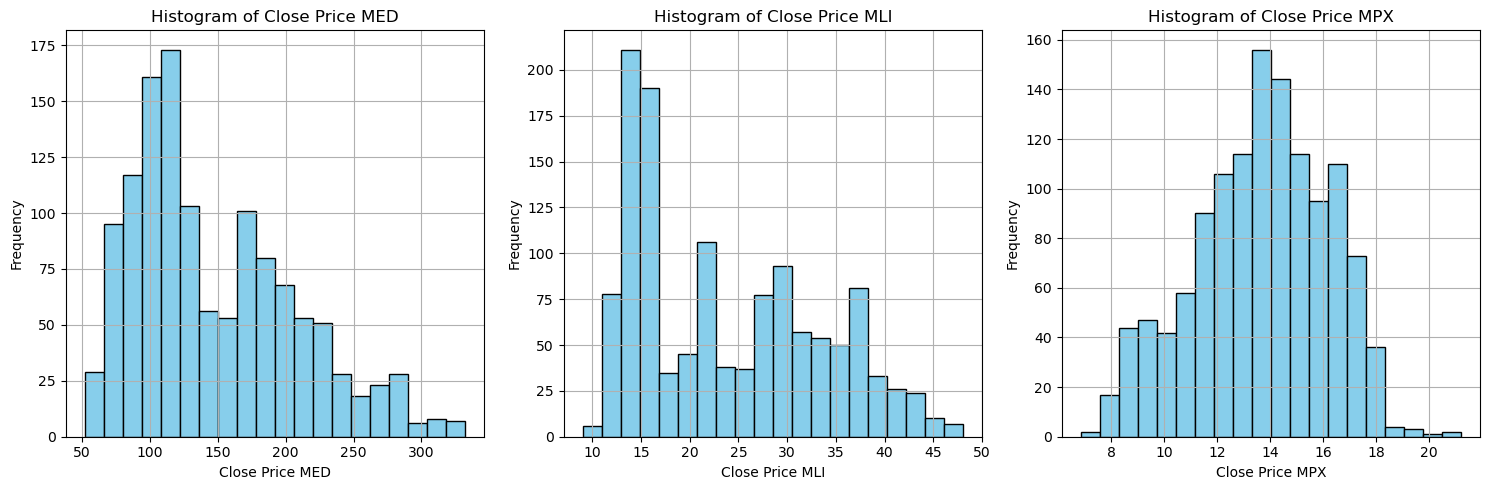

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with three subplots

# Plot histogram for dataframe 1
axs[0].hist(df_MED['Close'], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title('Histogram of Close Price MED')
axs[0].set_xlabel('Close Price MED')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

# Plot histogram for dataframe 2
axs[1].hist(df_MLI['Close'], bins=20, color='skyblue', edgecolor='black')
axs[1].set_title('Histogram of Close Price MLI')
axs[1].set_xlabel('Close Price MLI')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

# Plot histogram for dataframe 3
axs[2].hist(df_MPX['Close'], bins=20, color='skyblue', edgecolor='black')
axs[2].set_title('Histogram of Close Price MPX')
axs[2].set_xlabel('Close Price MPX')
axs[2].set_ylabel('Frequency')
axs[2].grid(True)

plt.tight_layout()  
plt.show()

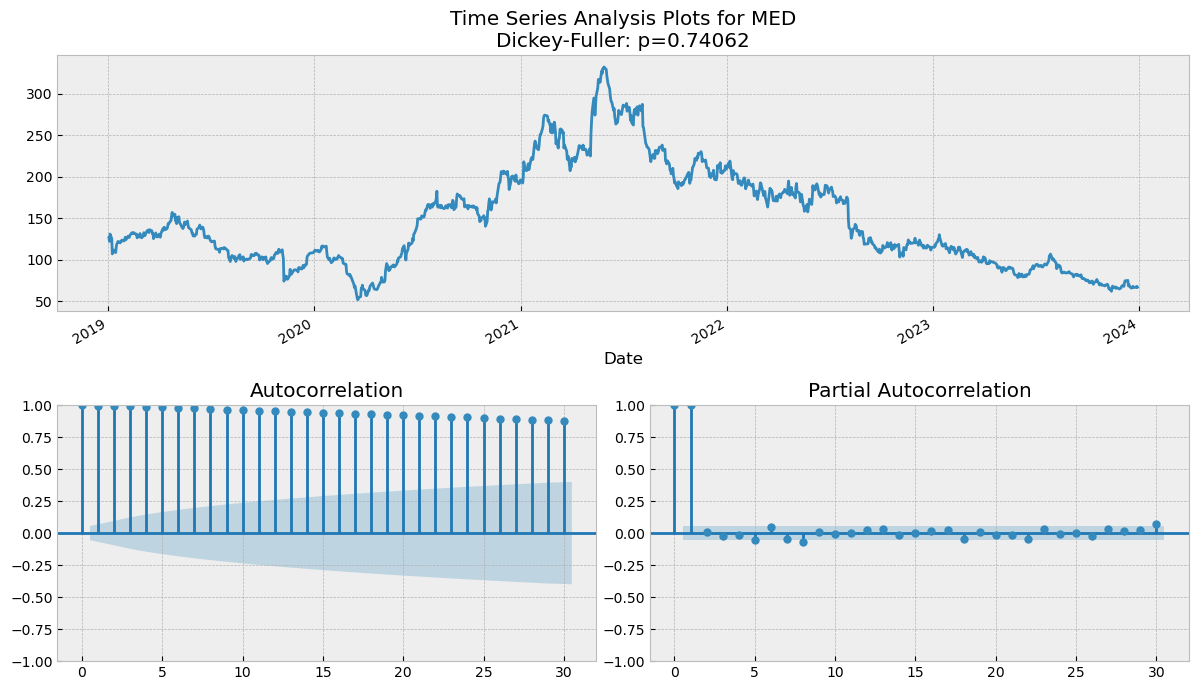

In [39]:
tsplot(df_MED["Close"],stock_name = "MED", lags=30)

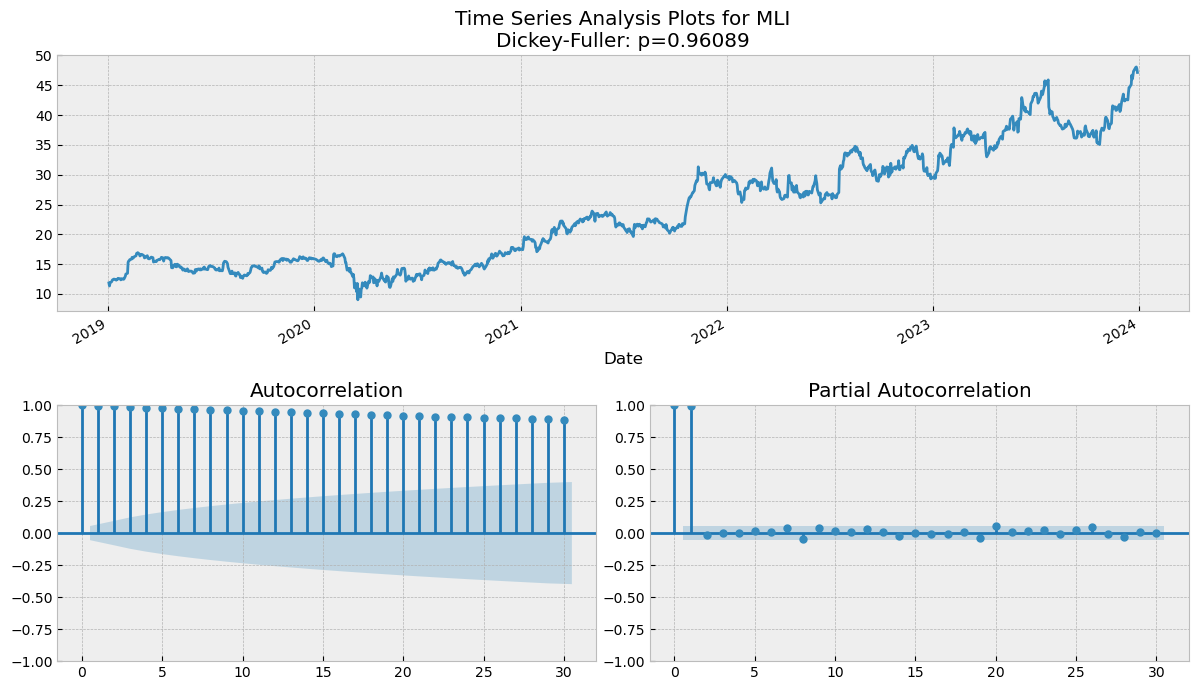

In [40]:
tsplot(df_MLI["Close"],stock_name = "MLI", lags=30)

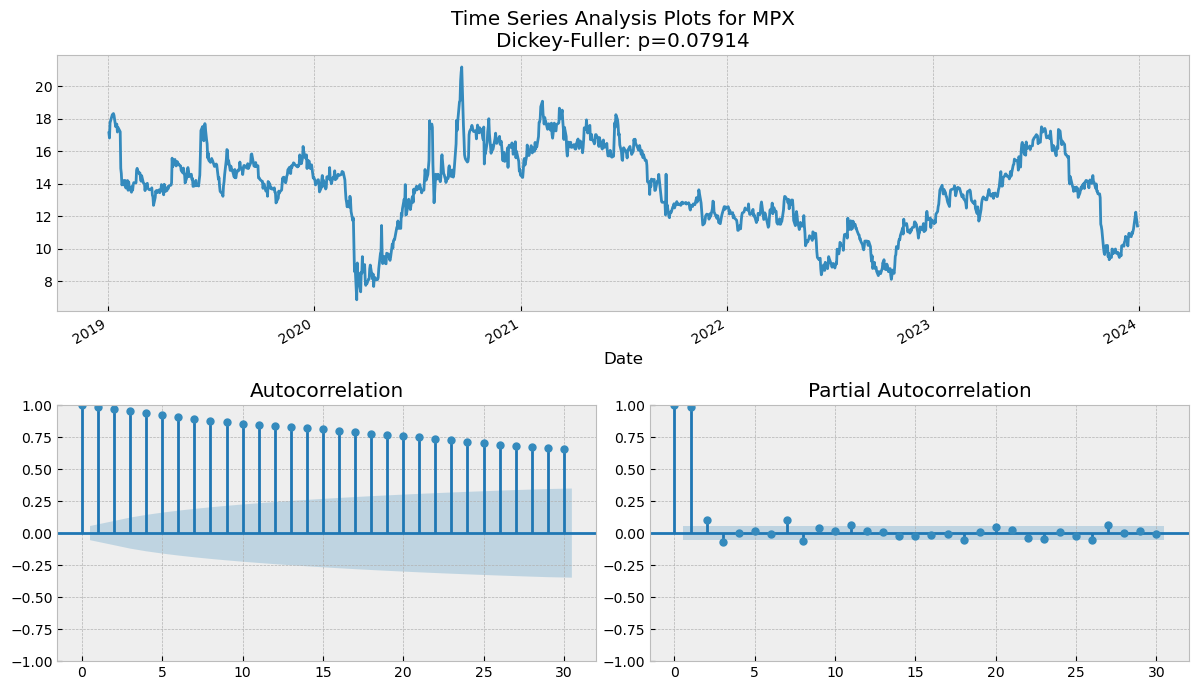

In [41]:
tsplot(df_MPX["Close"], stock_name = "MPX", lags=30)

The histograms of the close prices of these stocks indicate that the prices do not follow a normal distribution. Additionally, analysis using time series and the Augmented Dickey-Fuller (ADF) test reveals that the time series are not stationary. Consequently, it's prudent to calculate the returns to gain insight into the price dynamics.

By calculating returns, we can assess how the prices behave over time and potentially uncover trends or patterns that may not be apparent when examining raw price data alone. This approach helps in understanding the underlying dynamics of the stock prices and can aid in making informed investment decisions.

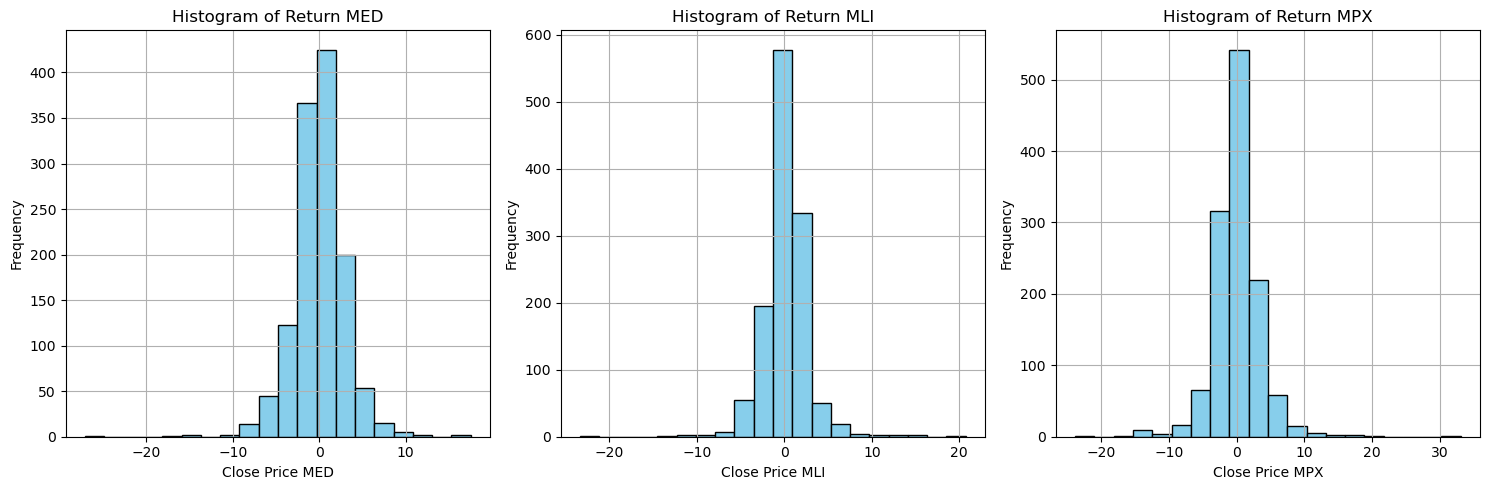

In [42]:
# calculate the return of close price 

df_MED['Return'] = 100*(df_MED['Close'].pct_change())
df_MLI['Return'] = 100*(df_MLI['Close'].pct_change())
df_MPX['Return'] = 100*(df_MPX['Close'].pct_change())

# fill nan values on the first row with zero
df_MED =  df_MED.fillna(0)
df_MLI =  df_MLI.fillna(0)
df_MPX =  df_MPX.fillna(0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with three subplots

# Plot histogram for dataframe 1
axs[0].hist(df_MED['Return'], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title('Histogram of Return MED')
axs[0].set_xlabel('Close Price MED')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

# Plot histogram for dataframe 2
axs[1].hist(df_MLI['Return'], bins=20, color='skyblue', edgecolor='black')
axs[1].set_title('Histogram of Return MLI')
axs[1].set_xlabel('Close Price MLI')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

# Plot histogram for dataframe 3
axs[2].hist(df_MPX['Return'], bins=20, color='skyblue', edgecolor='black')
axs[2].set_title('Histogram of Return MPX')
axs[2].set_xlabel('Close Price MPX')
axs[2].set_ylabel('Frequency')
axs[2].grid(True)

plt.tight_layout()  
plt.show()

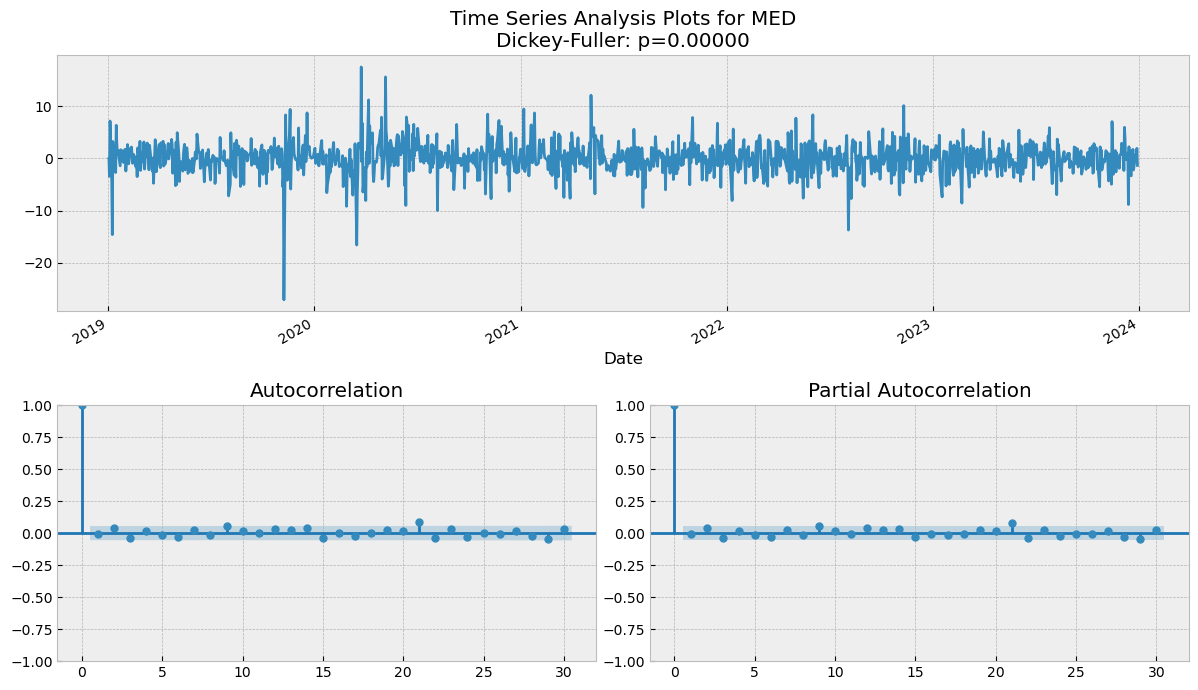

In [43]:
tsplot(df_MED["Return"],stock_name = "MED", lags=30)

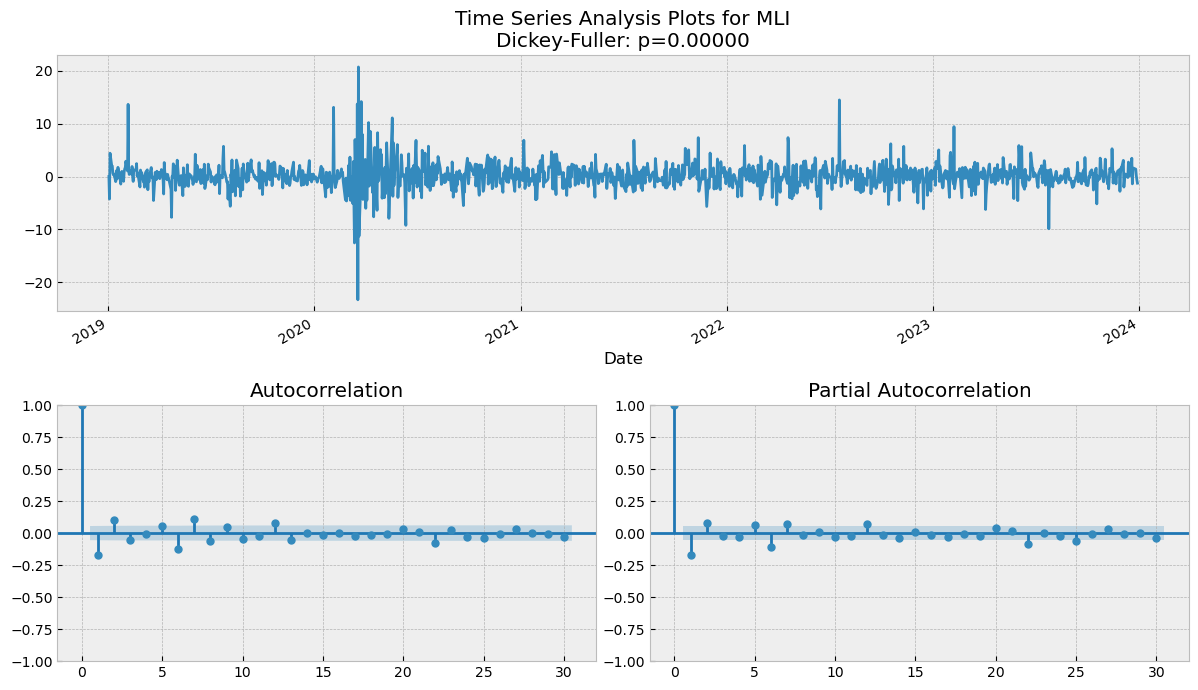

In [44]:
tsplot(df_MLI["Return"],stock_name = "MLI", lags=30)

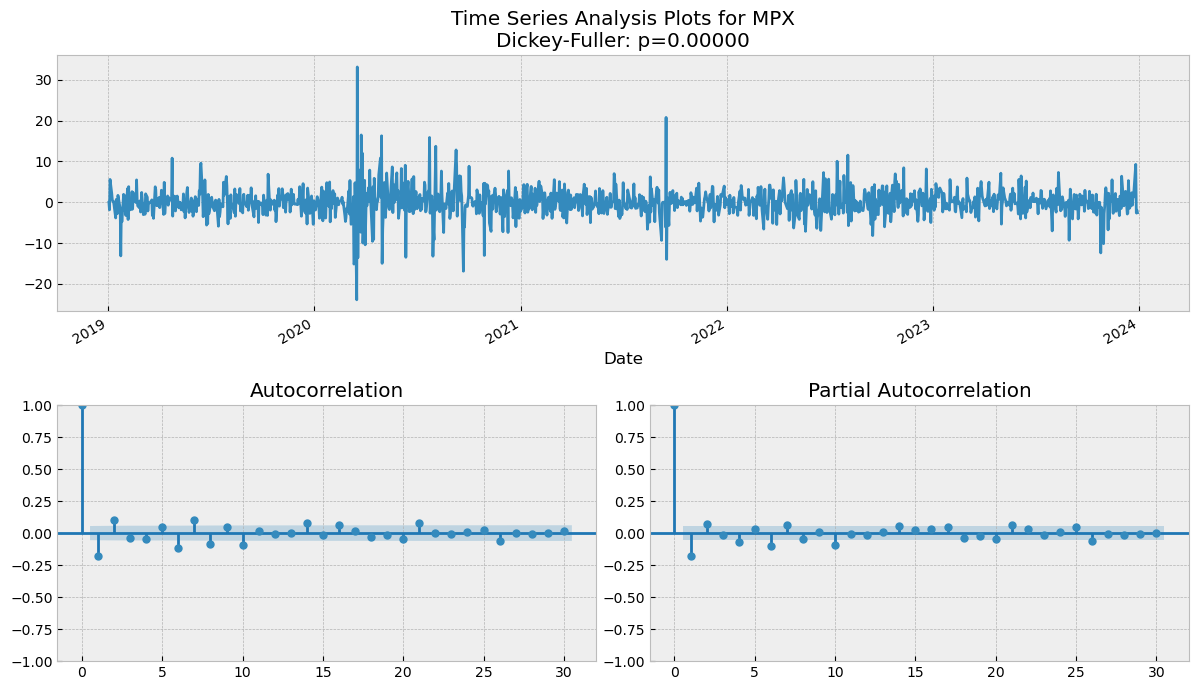

In [45]:
tsplot(df_MPX["Return"],stock_name = "MPX", lags=30)

#### MED

In [46]:
model = pm.auto_arima(df_MED['Return'].values, start_p=1, start_q=1,
                      test='adf',
                      max_p=4, max_q=4,
                      m=1,
                      d=None,
                      seasonal=False,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6376.434, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6374.180, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6376.095, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6376.101, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6376.178, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.373 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:                        SARIMAX   Log Likelihood               -3186.090
Date:                Mon, 22 Apr 2024   AIC                           6374.180
Time:                        20:13:49   BIC                           6379.317
Sample:                             0   HQIC                          6376.110
                               - 1258                                       

In [47]:
p=model.order[0]
d=model.order[1]
q=model.order[2]
if model.seasonal_order != None:
    P = model.seasonal_order[0]
    D = model.seasonal_order[1]
    Q = model.seasonal_order[2]
    s = model.seasonal_order[3]
else:
    P=0
    D=0
    Q=0
    s=0

In [48]:
arma_model_fit_MED=sm.tsa.statespace.SARIMAX(df_MED['Return'].values, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s), trend='n', enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
arma_model_fit_MED.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1258
Model:                        SARIMAX   Log Likelihood               -3184.057
Date:                Mon, 22 Apr 2024   AIC                           6370.114
Time:                        20:13:53   BIC                           6375.250
Sample:                             0   HQIC                          6372.044
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         9.2835      0.167     55.611      0.000       8.956       9.611
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              3275.00
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

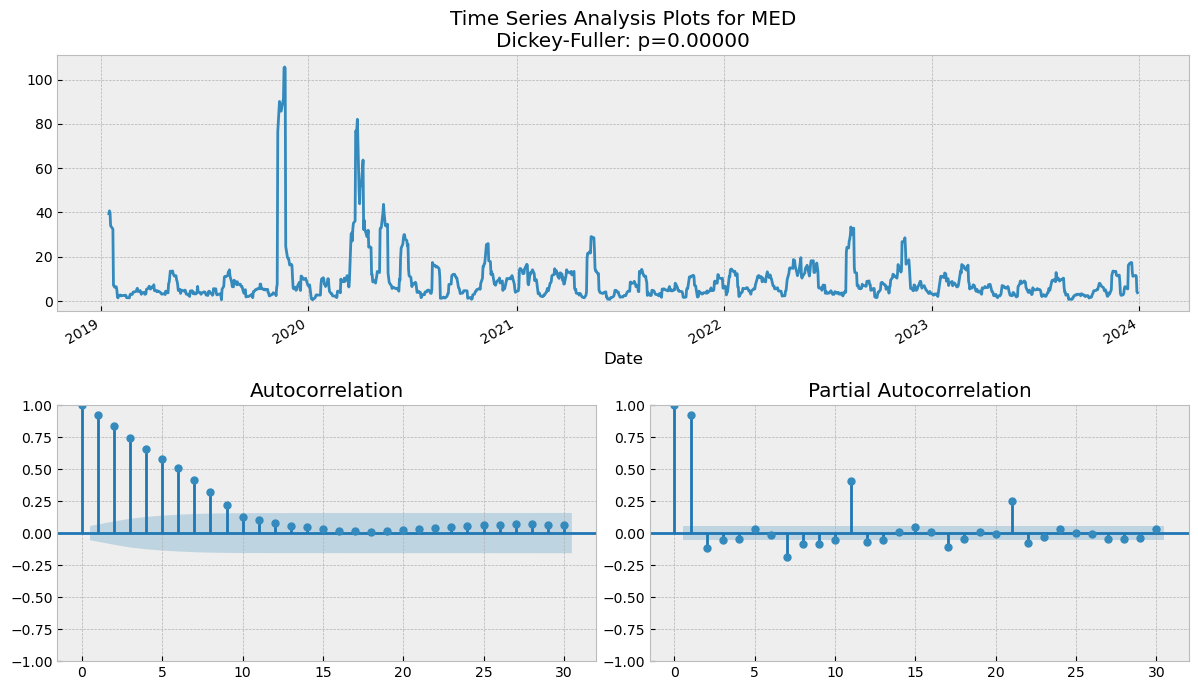

In [49]:
df_MED['Variance'] = (df_MED['Return'].rolling(10).std())**2
df_MED.dropna(inplace=True)

tsplot(df_MED["Variance"],stock_name = "MED", lags=30)

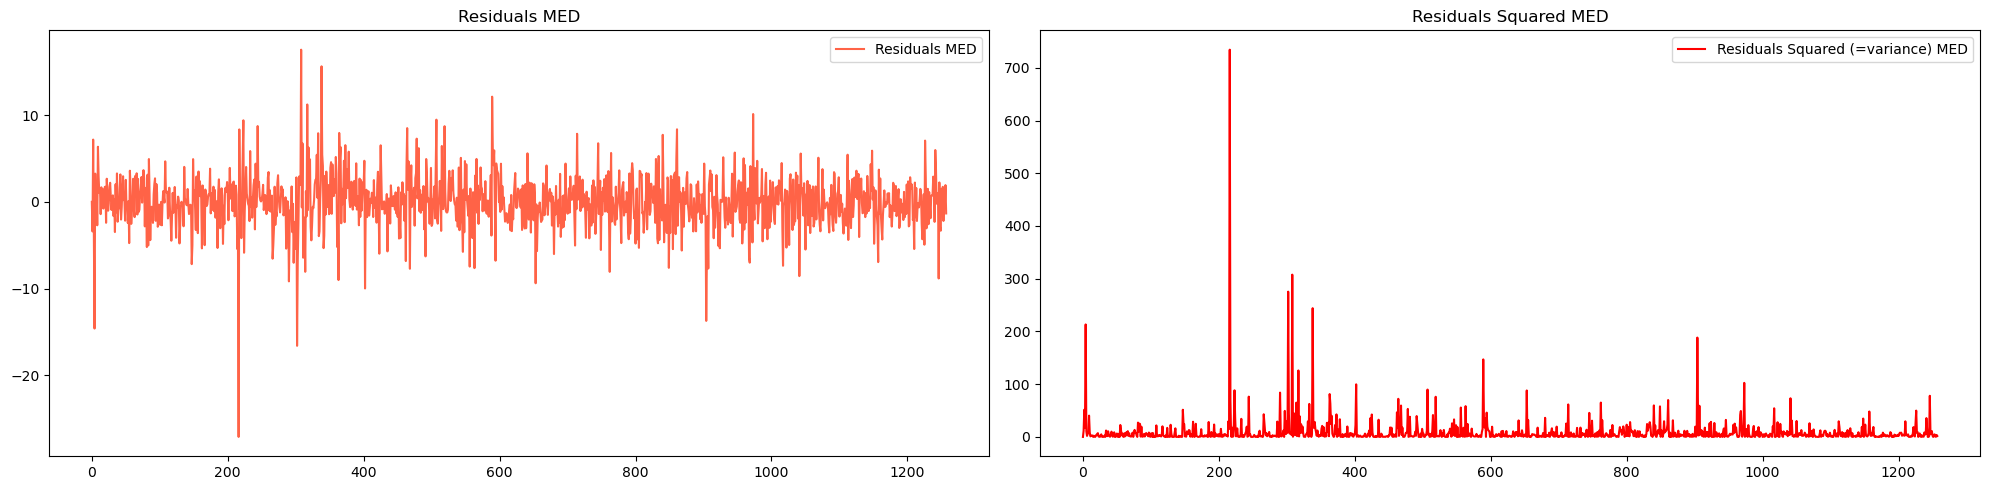

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot the residuals
axs[0].plot(pd.Series(arma_model_fit_MED.resid), color='tomato', label='Residuals MED')
axs[0].legend(loc='upper right')
axs[0].set_title('Residuals MED')

# Plot the squared residuals
axs[1].plot(pd.Series(arma_model_fit_MED.resid**2), color='red', label='Residuals Squared (=variance) MED')
axs[1].legend(loc='upper right')
axs[1].set_title('Residuals Squared MED')

plt.tight_layout()
plt.show()

In [51]:
from scipy.stats import probplot, moment

def plot_probplot(x, lags=None, title=None): 
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    probplot(x, plot=axes)
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes.text(x=.02, y=.75, s=s, transform=axes.transAxes)
    plt.title(title)
    plt.show()

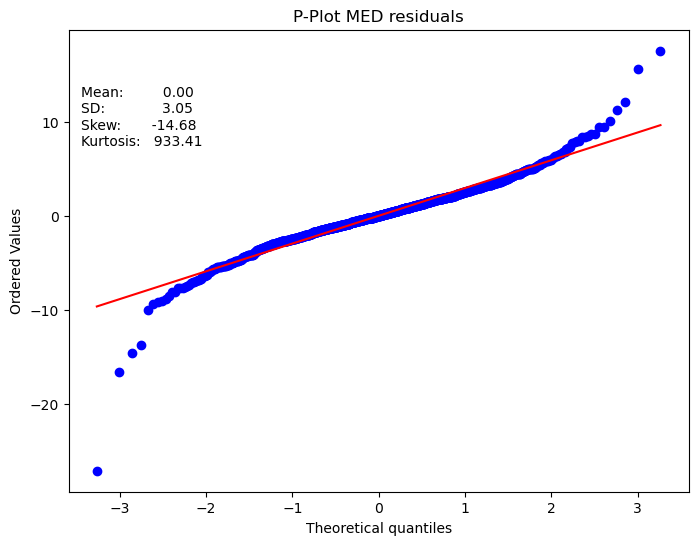

In [52]:
plot_probplot(arma_model_fit_MED.resid, lags=None, title="P-Plot MED residuals")

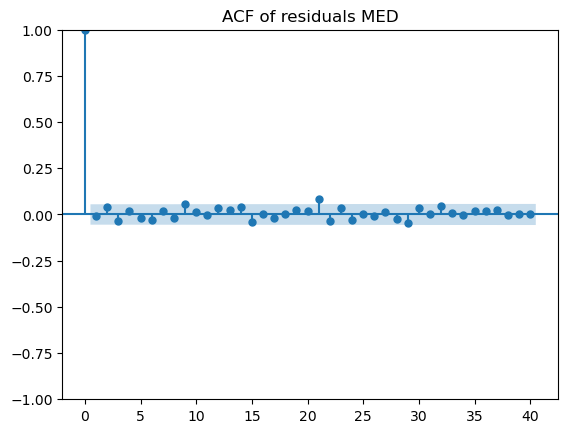

,lb_stat,lb_pvalue
100,121.138531,0.073931


In [53]:
# ACF plot
plot_acf(arma_model_fit_MED.resid, lags=40)
plt.title('ACF of residuals MED')
plt.show()
sms.diagnostic.acorr_ljungbox(arma_model_fit_MED.resid, lags=[100], boxpierce=False)

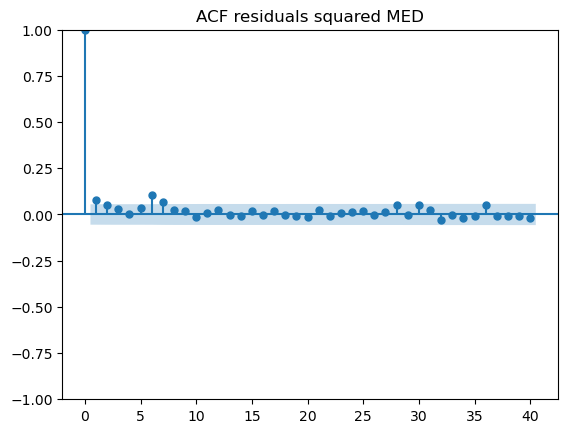

,lb_stat,lb_pvalue
100,178.115731,0.000003


In [54]:
# ACF plot
plot_acf(arma_model_fit_MED.resid**2, lags=40)
plt.title('ACF residuals squared MED')
plt.show()
sms.diagnostic.acorr_ljungbox(arma_model_fit_MED.resid**2, lags=[100], boxpierce=False)

#### MLI

In [55]:
model = pm.auto_arima(df_MLI['Return'].values, start_p=1, start_q=1,
                      test='adf',
                      max_p=4, max_q=4,
                      m=1,
                      d=None,
                      seasonal=False,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5903.681, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5941.501, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5908.847, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5914.168, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5903.923, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5903.472, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5904.642, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5880.952, Time=0.33 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=5882.832, Time=0.78 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5882.822, Time=0.45 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=5904.134, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5905.521, Time=0.25 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=5884.939, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5878.142, Time=0.63 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept

In [56]:
p=model.order[0]
d=model.order[1]
q=model.order[2]
if model.seasonal_order != None:
    P = model.seasonal_order[0]
    D = model.seasonal_order[1]
    Q = model.seasonal_order[2]
    s = model.seasonal_order[3]
else:
    P=0
    D=0
    Q=0
    s=0
    
arma_model_fit_MLI=sm.tsa.statespace.SARIMAX(df_MED['Return'].values, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s), trend='n', enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
arma_model_fit_MLI.summary()    

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1249
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -3139.399
Date:                Mon, 22 Apr 2024   AIC                           6288.799
Time:                        20:14:13   BIC                           6314.437
Sample:                             0   HQIC                          6298.439
                               - 1249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2123      0.314     -3.857      0.000      -1.828      -0.596
ar.L2         -0.5697      0.252     -2.260      0.024      -1.064      -0.076
ma.L1          1.2076      0.308      3.921      0.000       0.604       1.811
ma.L2          0.6051      0.235      2.575      0.010       0.145       1.066
sigma2         9.0239      0.172     52.395      0.000       8.686       9.361
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3202.35
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

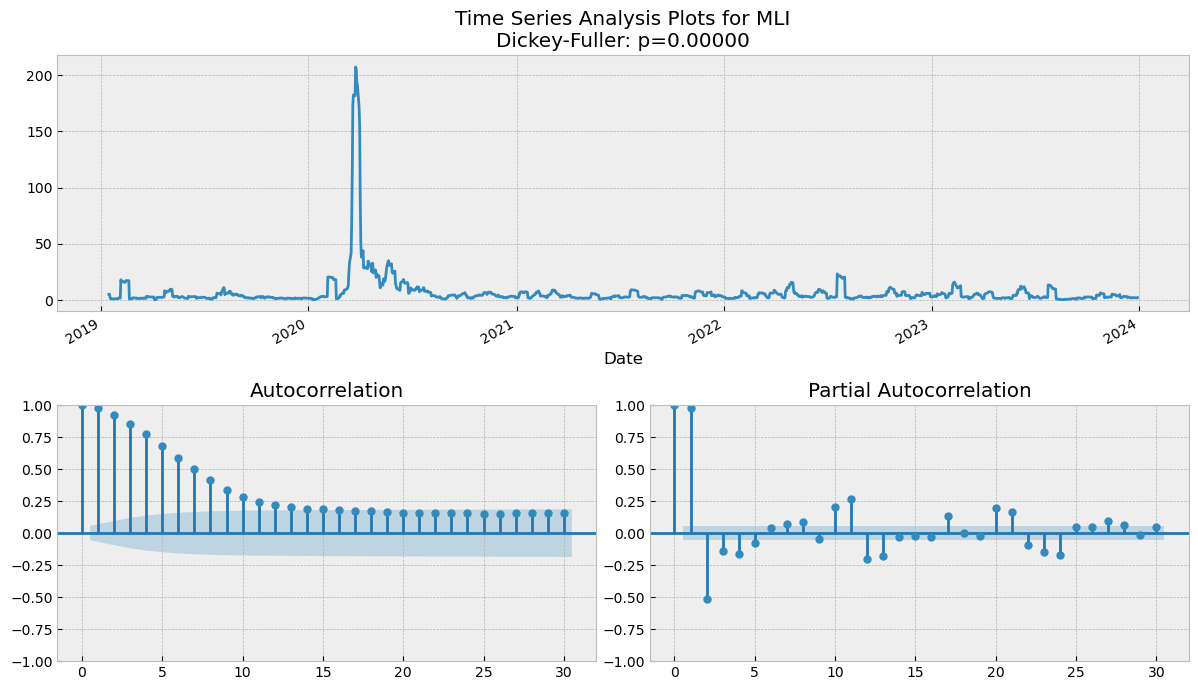

In [57]:
df_MLI['Variance'] = (df_MLI['Return'].rolling(10).std())**2
df_MLI.dropna(inplace=True)
tsplot(df_MLI["Variance"],stock_name = "MLI", lags=30)

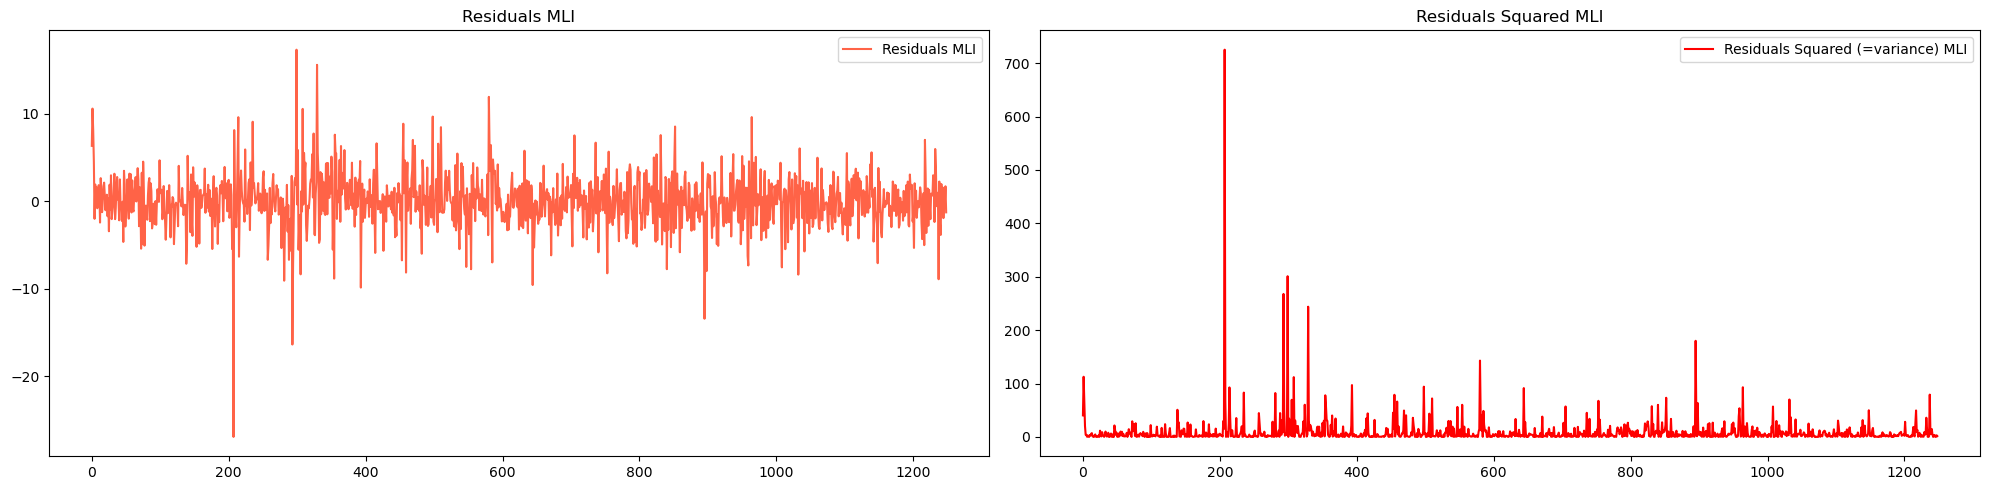

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot the residuals
axs[0].plot(pd.Series(arma_model_fit_MLI.resid), color='tomato', label='Residuals MLI')
axs[0].legend(loc='upper right')
axs[0].set_title('Residuals MLI')

# Plot the squared residuals
axs[1].plot(pd.Series(arma_model_fit_MLI.resid**2), color='red', label='Residuals Squared (=variance) MLI')
axs[1].legend(loc='upper right')
axs[1].set_title('Residuals Squared MLI')

plt.tight_layout()
plt.show()

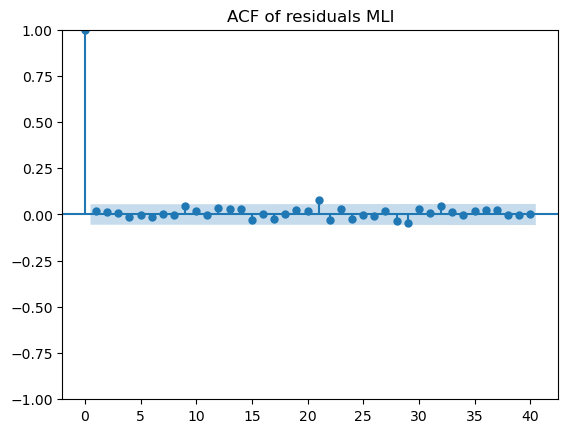

,lb_stat,lb_pvalue
100,108.22094,0.269955


In [59]:
# ACF plot
plot_acf(arma_model_fit_MLI.resid, lags=40)
plt.title('ACF of residuals MLI')
plt.show()
sms.diagnostic.acorr_ljungbox(arma_model_fit_MLI.resid, lags=[100], boxpierce=False)

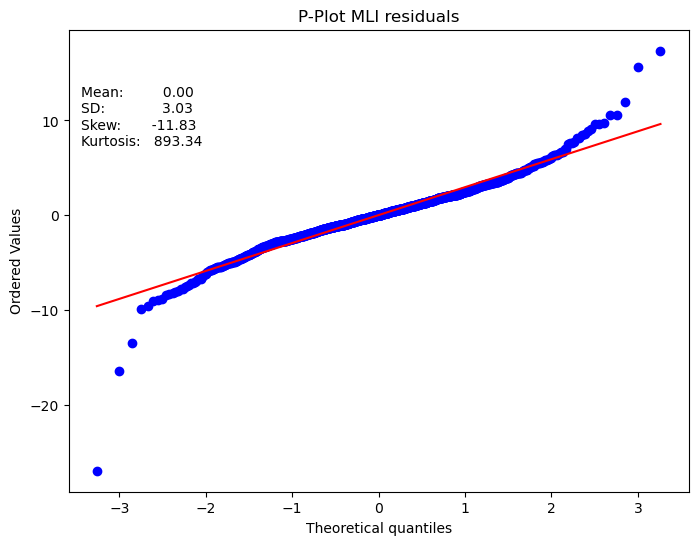

In [60]:
plot_probplot(arma_model_fit_MLI.resid, lags=None, title="P-Plot MLI residuals")

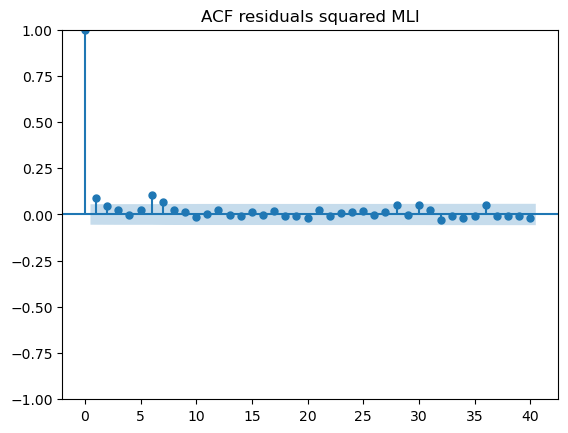

,lb_stat,lb_pvalue
100,184.417583,5.792215e-07


In [61]:
# ACF plot
plot_acf(arma_model_fit_MLI.resid**2, lags=40)
plt.title('ACF residuals squared MLI')
plt.show()
sms.diagnostic.acorr_ljungbox(arma_model_fit_MLI.resid**2, lags=[100], boxpierce=False)

### MPX

In [62]:
model = pm.auto_arima(df_MPX['Return'].values, start_p=1, start_q=1,
                      test='adf',
                      max_p=4, max_q=4,
                      m=1,
                      d=None,
                      seasonal=False,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6725.537, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6769.348, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6728.740, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6734.727, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6726.252, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6725.645, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6726.024, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6724.308, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=6726.144, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6724.392, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6726.190, Time=0.17 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 1.312 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1

In [63]:
p=model.order[0]
d=model.order[1]
q=model.order[2]
if model.seasonal_order != None:
    P = model.seasonal_order[0]
    D = model.seasonal_order[1]
    Q = model.seasonal_order[2]
    s = model.seasonal_order[3]
else:
    P=0
    D=0
    Q=0
    s=0
    
arma_model_fit_MPX=sm.tsa.statespace.SARIMAX(df_MPX['Return'].values, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s), trend='n', enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
arma_model_fit_MPX.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -3354.649
Date:                Mon, 22 Apr 2024   AIC                           6715.298
Time:                        20:15:15   BIC                           6730.705
Sample:                             0   HQIC                          6721.089
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1695      0.014    -11.934      0.000      -0.197      -0.142
ar.L2          0.0715      0.020      3.648      0.000       0.033       0.110
sigma2        12.2304      0.245     49.843      0.000      11.749      12.711
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3610.53
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

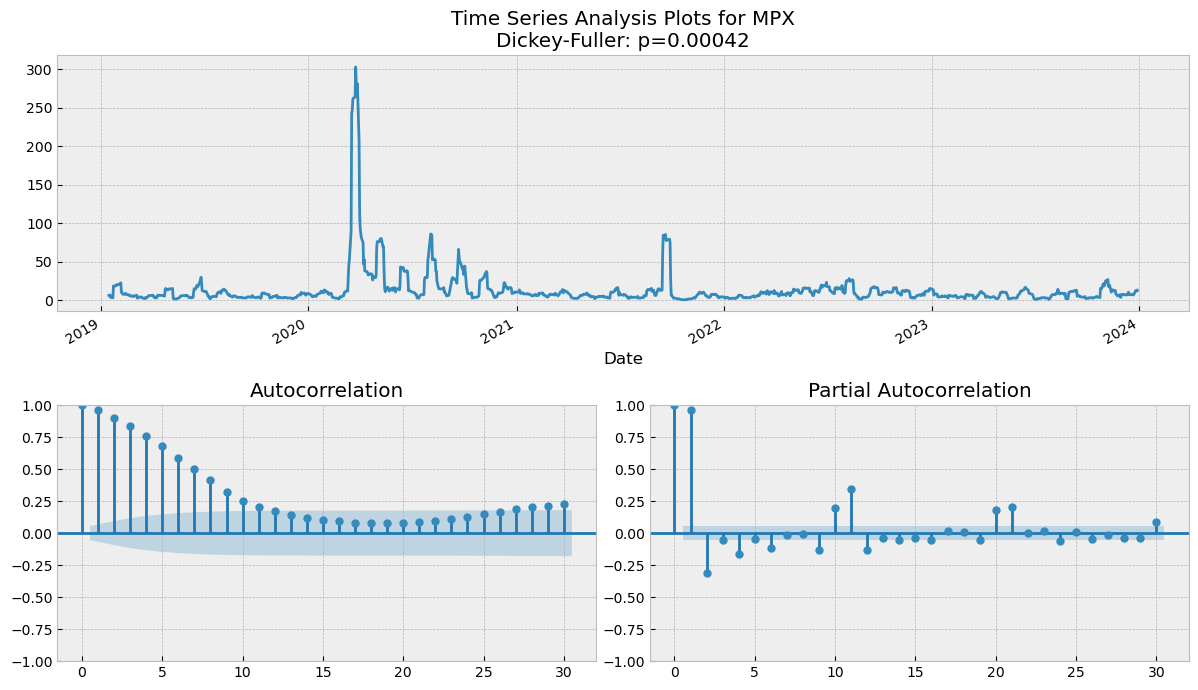

In [64]:
df_MPX['Variance'] = (df_MPX['Return'].rolling(10).std())**2
df_MPX.dropna(inplace=True)

tsplot(df_MPX["Variance"],stock_name = "MPX", lags=30)

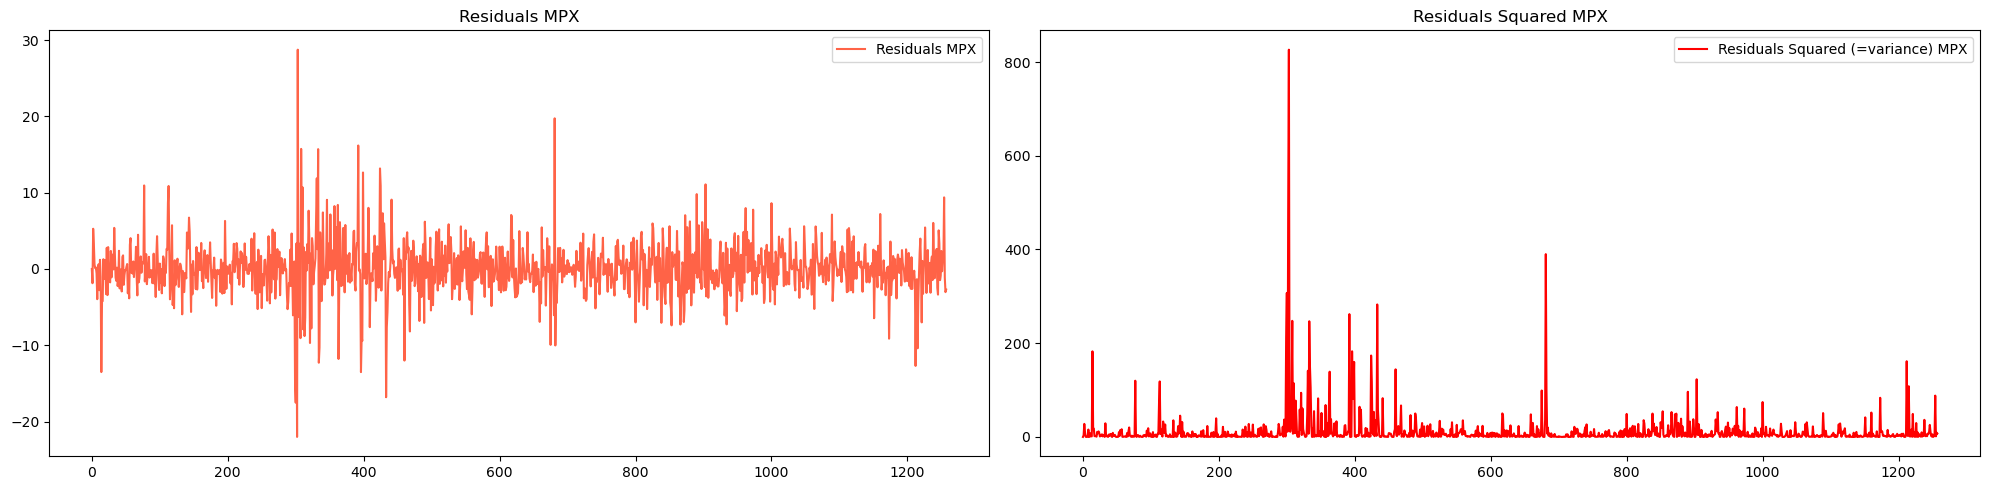

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot the residuals
axs[0].plot(pd.Series(arma_model_fit_MPX.resid), color='tomato', label='Residuals MPX')
axs[0].legend(loc='upper right')
axs[0].set_title('Residuals MPX')

# Plot the squared residuals
axs[1].plot(pd.Series(arma_model_fit_MPX.resid**2), color='red', label='Residuals Squared (=variance) MPX')
axs[1].legend(loc='upper right')
axs[1].set_title('Residuals Squared MPX')

plt.tight_layout()
plt.show()

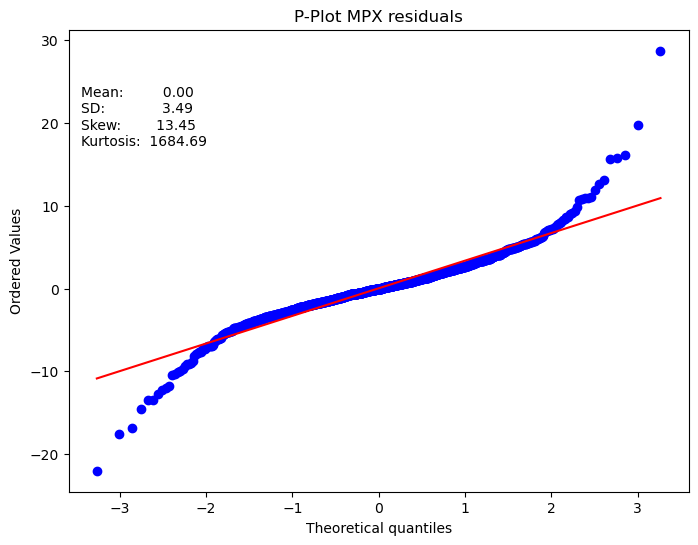

In [66]:
plot_probplot(arma_model_fit_MPX.resid, lags=None, title="P-Plot MPX residuals")

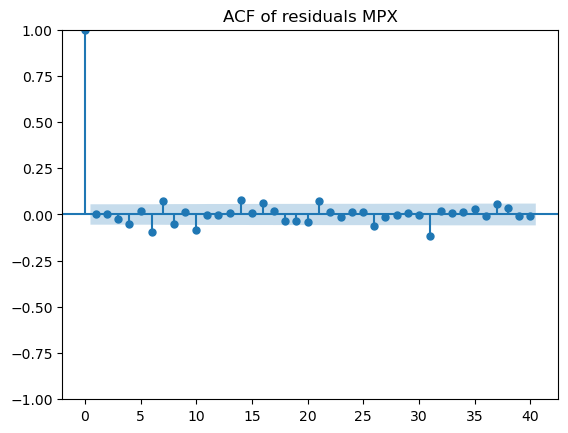

,lb_stat,lb_pvalue
100,176.327674,0.000004


In [67]:
# ACF plot
plot_acf(arma_model_fit_MPX.resid, lags=40)
plt.title('ACF of residuals MPX')
plt.show()
sms.diagnostic.acorr_ljungbox(arma_model_fit_MPX.resid, lags=[100], boxpierce=False)

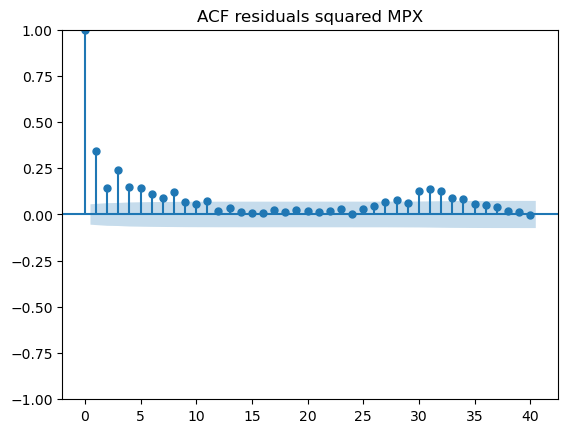

,lb_stat,lb_pvalue
100,618.220487,1.151391e-75


In [68]:
# ACF plot
plot_acf(arma_model_fit_MPX.resid**2, lags=40)
plt.title('ACF residuals squared MPX')
plt.show()
sms.diagnostic.acorr_ljungbox(arma_model_fit_MPX.resid**2, lags=[100], boxpierce=False)

#### ARCH Model

In [69]:
def simulate_GARCH(n=1000, omega=0, alpha=0, beta=0):
    np.random.seed(12345)
    n1 = 100          # Number of initial observations to drop
    n2 = n + n1       # Total number of observations including initial ones
    errors = np.random.normal(0, 1, n2)  # White noise errors
    eps = np.zeros(n2)  # GARCH residuals
    sigsq = np.zeros(n2)  # GARCH variance

    # Generate initial GARCH residual and variance
    eps[0] = np.random.normal(0, np.sqrt(omega / (1 - alpha)), 1)
    sigsq[0] = eps[0]

    # Generate subsequent GARCH residuals and variance
    for i in range(1, n2 - 1):
        eps[i] = errors[i] * np.sqrt(omega + alpha * errors[i - 1] ** 2 + beta * eps[i - 1] ** 2)
        sigsq[i] = omega + alpha * errors[i - 1] ** 2 + beta * eps[i - 1] ** 2

    # Return simulated GARCH residuals and variance, excluding initial transient period
    return eps[n1 - 1:-1], sigsq[n1 - 1:-1]

##### MED

To predict volatility, we start with traditional models and first calulate the daily variance ,
then we use arch model to forecast the variance in the year 2022- 2023, evaluate the model



In [70]:
# choose the best model of ARCH
trainsize = 3 * 252  # 3 years
data = df_MED['Return'].clip(lower=df_MED['Return'].quantile(0.05),
                              upper=df_MED['Return'].quantile(0.95))
T = len(df_MED['Return'])
results = {}

for p in range(1, 5):
    print(f'{p} | {0}')
    result = []
    for s, t in enumerate(range(trainsize, T-1)):
        train_set = data.iloc[s: t]
        test_set = data.iloc[t]  # 1-step ahead forecast
        model = arch_model(y=train_set, p=p, q=1).fit(disp='off')  # Adjust q as necessary
        forecast = model.forecast(horizon=1)
        mu = forecast.mean.iloc[-1, 0]
        var = forecast.variance.iloc[-1, 0]
        result.append([(test_set-mu)**2, var])
    df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
    results[(p, 0)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 0
2 | 0
3 | 0
4 | 0


In [71]:
results

{(1, 0): 6.687570531154633,
 (2, 0): 6.7207503637951485,
 (3, 0): 6.716854500942391,
 (4, 0): 6.725666776282062}

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3139.05
Distribution:                  Normal   AIC:                           6282.10
Method:            Maximum Likelihood   BIC:                           6292.36
                                        No. Observations:                 1249
Date:                Mon, Apr 22 2024   Df Residuals:                     1249
Time:                        20:17:06   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          7.7598      0.748     10.378  3.113e-25 [  6.294,  9.22

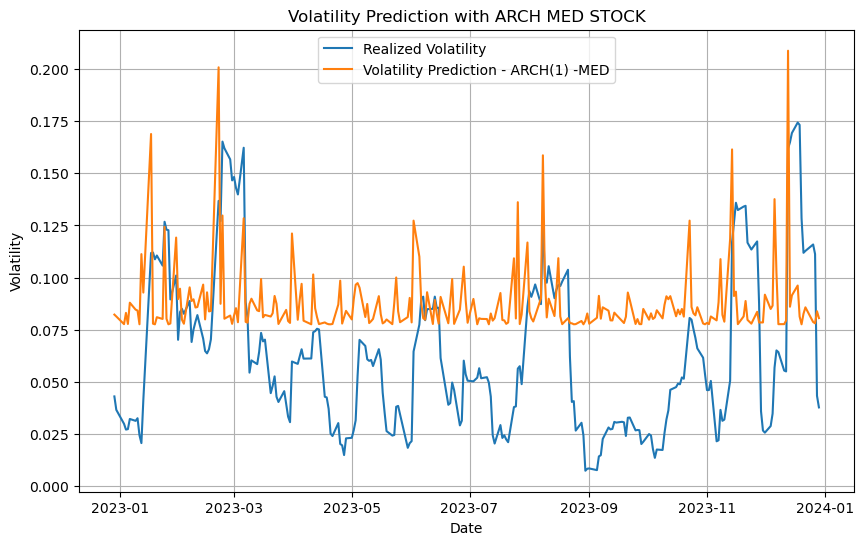

In [72]:
n = 252
split_date = df_MED['Return'].iloc[-n:].index

arch = arch_model(df_MED['Return'], mean='zero', vol='ARCH', p=1).fit(disp='off')

print(arch.summary())


forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

#????
rmse_arch = np.sqrt(mse(df_MED['Variance'][-n:] / 100, forecast_arch.variance / 100))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

plt.figure(figsize=(10, 6))
plt.plot(df_MED['Variance'][-n:] / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance / 100,
         label='Volatility Prediction - ARCH(1) -MED')
plt.title('Volatility Prediction with ARCH MED STOCK', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

##### MLI

In [73]:
# choose the best model of ARCH

trainsize = 3 * 252  # 3 years
data = df_MLI['Return'].clip(lower=df_MLI['Return'].quantile(0.05),
                              upper=df_MLI['Return'].quantile(0.95))
T = len(df_MLI['Return'])
results = {}

for p in range(1, 5):
    print(f'{p} | {0}')
    result = []
    for s, t in enumerate(range(trainsize, T-1)):
        train_set = data.iloc[s: t]
        test_set = data.iloc[t]  # 1-step ahead forecast
        model = arch_model(y=train_set, p=p, q=1).fit(disp='off')  # Adjust q as necessary
        forecast = model.forecast(horizon=1)
        mu = forecast.mean.iloc[-1, 0]
        var = forecast.variance.iloc[-1, 0]
        result.append([(test_set-mu)**2, var])
    df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
    results[(p, 0)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 0
2 | 0
3 | 0
4 | 0


In [74]:
results

{(1, 0): 3.9458179327126874,
 (2, 0): 3.94504579526177,
 (3, 0): 3.9457550237662256,
 (4, 0): 3.9411574532604545}

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -2787.62
Distribution:                  Normal   AIC:                           5585.23
Method:            Maximum Likelihood   BIC:                           5610.89
                                        No. Observations:                 1249
Date:                Mon, Apr 22 2024   Df Residuals:                     1249
Time:                        20:18:40   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          3.0496      0.405      7.535  4.897e-14    [  

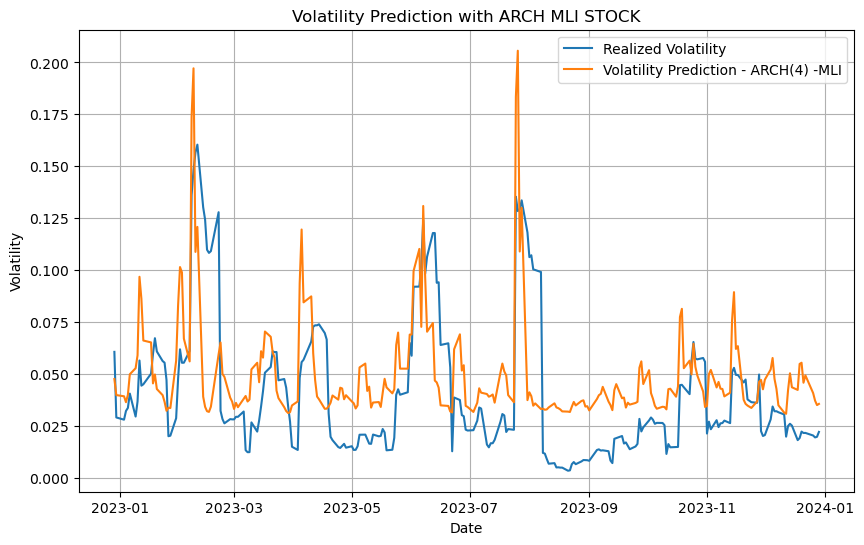

In [75]:
n = 252
split_date = df_MLI['Return'].iloc[-n:].index

arch = arch_model(df_MLI['Return'], mean='zero', vol='ARCH', p=4).fit(disp='off')

print(arch.summary())


forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

#????
rmse_arch = np.sqrt(mse(df_MLI['Variance'][-n:] / 100, forecast_arch.variance / 100))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

plt.figure(figsize=(10, 6))
plt.plot(df_MLI['Variance'][-n:] / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance / 100,
         label='Volatility Prediction - ARCH(4) -MLI')
plt.title('Volatility Prediction with ARCH MLI STOCK', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

##### MPX

In [76]:
# choose the best model of ARCH

trainsize = 3 * 252  # 3 years
data = df_MPX['Return'].clip(lower=df_MPX['Return'].quantile(0.05),
                              upper=df_MPX['Return'].quantile(0.95))
T = len(df_MPX['Return'])
results = {}

for p in range(1, 5):
    print(f'{p} | {0}')
    result = []
    for s, t in enumerate(range(trainsize, T-1)):
        train_set = data.iloc[s: t]
        test_set = data.iloc[t]  # 1-step ahead forecast
        model = arch_model(y=train_set, p=p, q=1).fit(disp='off')  # Adjust q as necessary
        forecast = model.forecast(horizon=1)
        mu = forecast.mean.iloc[-1, 0]
        var = forecast.variance.iloc[-1, 0]
        result.append([(test_set-mu)**2, var])
    df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
    results[(p, 0)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 0
2 | 0
3 | 0
4 | 0


In [77]:
results

{(1, 0): 7.872112538205021,
 (2, 0): 7.874445941121733,
 (3, 0): 7.869345382543153,
 (4, 0): 7.876028598732431}

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3222.91
Distribution:                  Normal   AIC:                           6453.83
Method:            Maximum Likelihood   BIC:                           6474.35
                                        No. Observations:                 1249
Date:                Mon, Apr 22 2024   Df Residuals:                     1249
Time:                        20:20:17   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          6.6053      0.702      9.414  4.786e-21    [  

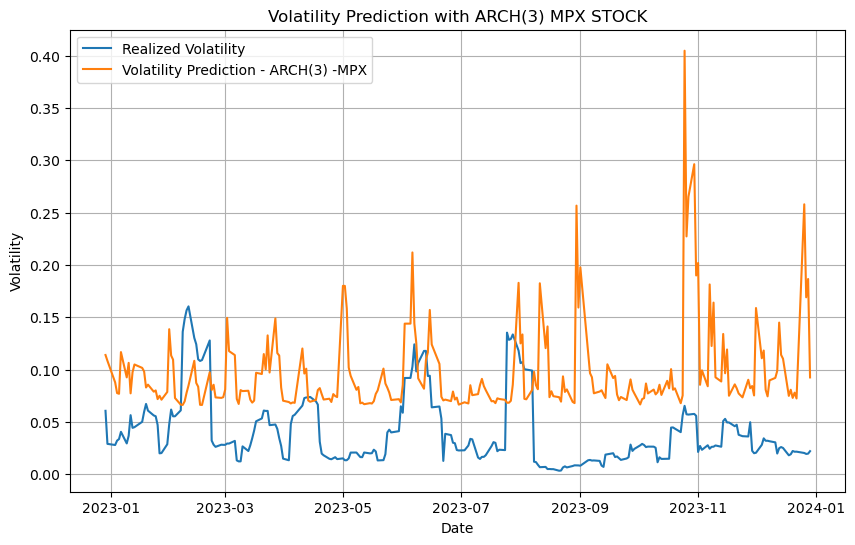

In [78]:
n = 252
split_date = df_MPX['Return'].iloc[-n:].index

arch = arch_model(df_MPX['Return'], mean='zero', vol='ARCH', p=3).fit(disp='off')

print(arch.summary())


forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

#????
rmse_arch = np.sqrt(mse(df_MPX['Variance'][-n:] / 100, forecast_arch.variance / 100))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

plt.figure(figsize=(10, 6))
plt.plot(df_MLI['Variance'][-n:] / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance / 100,
         label='Volatility Prediction - ARCH(3) -MPX')
plt.title('Volatility Prediction with ARCH(3) MPX STOCK', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

#### GARCH MODEL

##### MED

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3111.14
Distribution:                  Normal   AIC:                           6230.27
Method:            Maximum Likelihood   BIC:                           6250.79
                                        No. Observations:                 1249
Date:                Mon, Apr 22 2024   Df Residuals:                     1248
Time:                        20:20:19   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0235  7.834e-02     -0.300      0.764 [ -0.177,  0.13

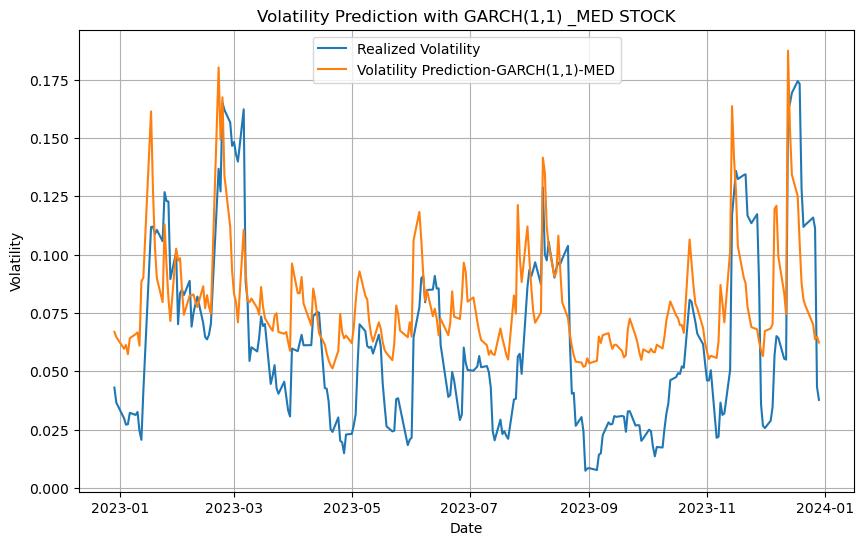

In [79]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(df_MED['Return'], mean='constant',vol='GARCH', p=p, o=0, q=q, dist = 'normal')\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch_MED = arch_model(df_MED['Return'], mean='constant', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1], dist = 'normal')\
        .fit(disp='off')
print(garch_MED.summary())
forecast = garch_MED.forecast(start=split_date[0])
forecast_garch_MED = forecast

# Calculate RMSE
rmse_arch = np.sqrt(mse(df_MED['Variance'][-n:] / 100, forecast_garch_MED.variance / 100))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_arch))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_MED['Variance'][-n:] / 100, label='Realized Volatility')
plt.plot(forecast_garch_MED.variance/100, label='Volatility Prediction-GARCH(1,1)-MED')
plt.title('Volatility Prediction with GARCH(1,1) _MED STOCK', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

##### MLI

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2788.73
Distribution:                  Normal   AIC:                           5585.46
Method:            Maximum Likelihood   BIC:                           5605.98
                                        No. Observations:                 1249
Date:                Mon, Apr 22 2024   Df Residuals:                     1248
Time:                        20:20:22   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1041  6.600e-02      1.578      0.115 [-2.52

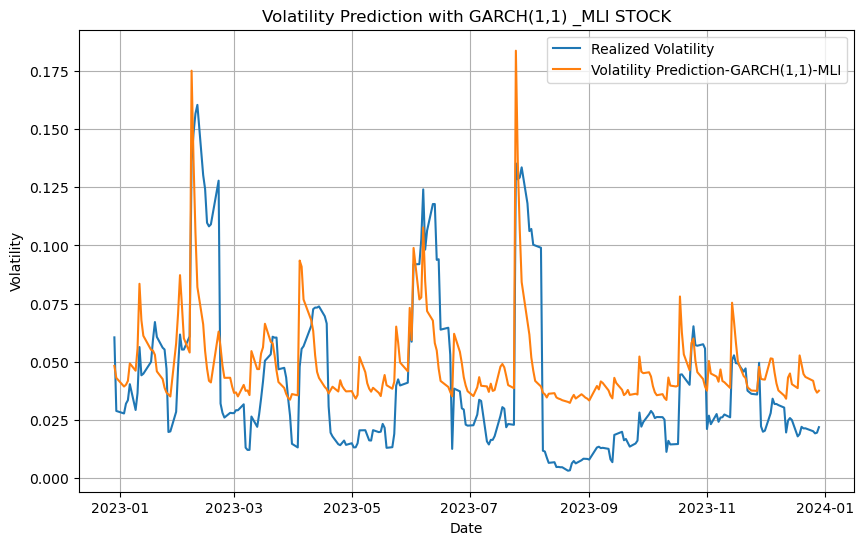

In [80]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(df_MLI['Return'], mean='constant',vol='GARCH', p=p, o=0, q=q, dist = 'normal')\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch_MLI = arch_model(df_MLI['Return'], mean='constant', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1], dist = 'normal')\
        .fit(disp='off')
print(garch_MLI.summary())

forecast = garch_MLI.forecast(start=split_date[0])
forecast_garch_MLI = forecast

# Calculate RMSE
rmse_arch = np.sqrt(mse(df_MLI['Variance'][-n:] / 100, forecast_garch_MLI.variance / 100))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_arch))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_MLI['Variance'][-n:] / 100, label='Realized Volatility')
plt.plot(forecast_garch_MLI.variance/ 100, label='Volatility Prediction-GARCH(1,1)-MLI')
plt.title('Volatility Prediction with GARCH(1,1) _MLI STOCK', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

##### MPX

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3205.82
Distribution:                  Normal   AIC:                           6431.64
Method:            Maximum Likelihood   BIC:                           6482.94
                                        No. Observations:                 1249
Date:                Mon, Apr 22 2024   Df Residuals:                     1248
Time:                        20:20:24   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0401  8.373e-02      0.479      0.632 [ -0.124,  0.20

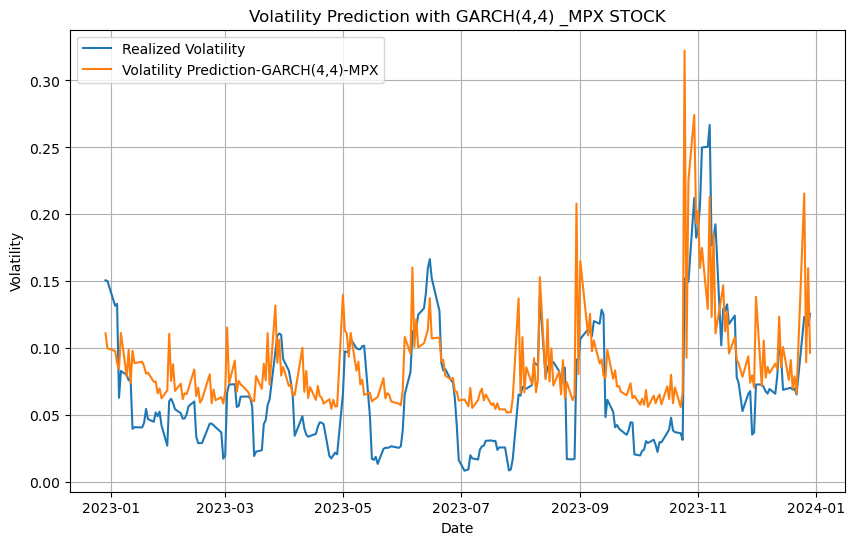

In [81]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(df_MPX['Return'], mean='constant',vol='GARCH', p=p, o=0, q=q, dist = 'normal')\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch_MPX = arch_model(df_MPX['Return'], mean='constant', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1], dist = 'normal')\
        .fit(disp='off')
print(garch.summary())
forecast = garch_MPX.forecast(start=split_date[0])
forecast_garch_MPX = forecast

# Calculate RMSE
rmse_arch = np.sqrt(mse(df_MPX['Variance'][-n:] / 100, forecast_garch_MPX.variance / 100))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_arch))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_MPX['Variance'][-n:] / 100, label='Realized Volatility')
plt.plot(forecast_garch_MPX.variance / 100, label='Volatility Prediction-GARCH(4,4)-MPX')
plt.title('Volatility Prediction with GARCH(4,4) _MPX STOCK', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

### SVR

#### MED

In [82]:
n = 252
df_MED["Return_svr"] = df_MED["Return"]**2
X_trainMED = df_MED[["Return_svr","Variance"]].iloc[:-n].values
y_trainMED = df_MED["Variance"].iloc[2:-(n-2)].values.reshape(-1,1)
X_testMED = df_MED[["Return_svr","Variance"]].iloc[-n:].values
y_testMED = df_MED["Variance"].iloc[-n:].values.reshape(-1,1)

In [83]:
# Define SVR models
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

models = [svr_poly, svr_lin, svr_rbf]

# Define parameter grid
param_grid = {'gamma': [0.001, 0.01, 0.1, 1],  
              'C': [0.001, 0.01, 0.1, 1],      
              'epsilon': [0.001, 0.01, 0.1, 1]}  

best_models = []
kf = KFold(n_splits=3, shuffle=False)  
for model in models:
    clf = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, cv=kf, random_state=42, n_jobs=-1)
    clf.fit(X_trainMED, y_trainMED)
    best_models.append(clf.best_estimator_)

# Predict using each best model
predictions = [model.predict(X_testMED) for model in best_models]

# Calculate RMSE for each prediction
rmses = [np.sqrt(mean_squared_error(y_testMED / 100, prediction / 100)) for prediction in predictions]

# Print RMSE for each model
for i, model in enumerate(models):
    print(f'The RMSE value of SVR with {model.kernel} Parameters {model.get_params()} Kernel is {rmses[i]:.6f}')
    print("\n" + "-" * 50 + "\n")

The RMSE value of SVR with poly Parameters {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False} Kernel is 0.032412

--------------------------------------------------

The RMSE value of SVR with linear Parameters {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False} Kernel is 0.005767

--------------------------------------------------

The RMSE value of SVR with rbf Parameters {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False} Kernel is 0.008318

--------------------------------------------------



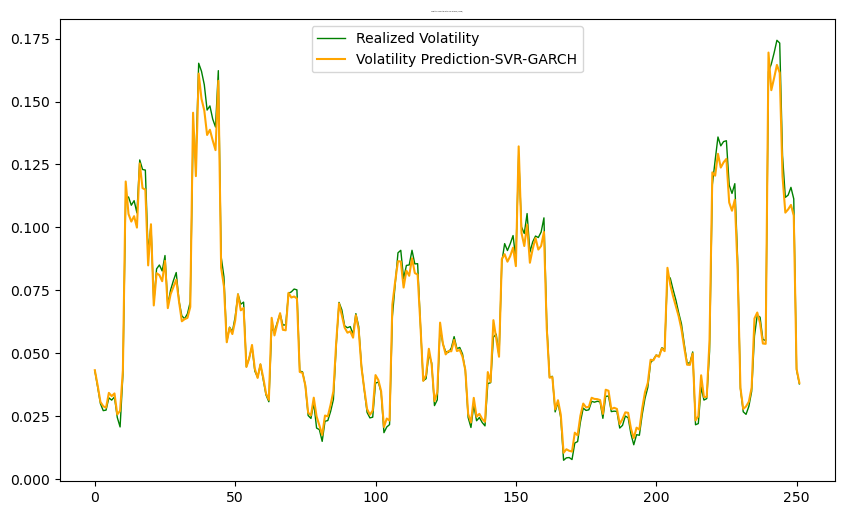

In [84]:
svr_poly = SVR(kernel='linear', C=1.0, cache_size=200, coef0=0.0, degree=3,
               epsilon=0.1, gamma='scale', max_iter=-1, shrinking=True,
               tol=0.001, verbose=False)

# Fit the SVR model to your training data
svr_poly.fit(X_trainMED, y_trainMED)

prediction = svr_poly.predict(X_testMED)

plt.figure(figsize=(10, 6))
plt.plot(y_testMED / 100, label='Realized Volatility', color='green', linewidth=1)
plt.plot(prediction / 100, label='Volatility Prediction-SVR-GARCH', color='orange')  
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=1)
plt.legend()
plt.show()

#### MLI

In [85]:
df_MLI["Return_svr"] = df_MLI["Return"]**2
X_trainMLI = df_MLI[["Return_svr","Variance"]].iloc[:-n].values
y_trainMLI = df_MLI["Variance"].iloc[2:-(n-2)].values.reshape(-1,1)
X_testMLI = df_MLI[["Return_svr","Variance"]].iloc[-n:].values
y_testMLI = df_MLI["Variance"].iloc[-n:].values.reshape(-1,1)


# Define SVR models
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

models = [svr_poly, svr_lin, svr_rbf]

# Define parameter grid
param_grid = {'gamma': [0.001, 0.01, 0.1, 1],  
              'C': [0.001, 0.01, 0.1, 1],      
              'epsilon': [0.001, 0.01, 0.1, 1]}  

best_models = []
kf = KFold(n_splits=3, shuffle=False)  
for model in models:
    clf = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, cv=kf, random_state=42, n_jobs=-1)
    clf.fit(X_trainMLI, y_trainMLI)
    best_models.append(clf.best_estimator_)

# Predict using each best model
predictions = [model.predict(X_testMLI) for model in best_models]

# Calculate RMSE for each prediction
rmses = [np.sqrt(mean_squared_error(y_testMLI / 100, prediction / 100)) for prediction in predictions]

# Print RMSE for each model
for i, model in enumerate(models):
    print(f'The RMSE value of SVR with {model.kernel} Parameters {model.get_params()} Kernel is {rmses[i]:.6f}')
    print("\n" + "-" * 50 + "\n")

The RMSE value of SVR with poly Parameters {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False} Kernel is 0.030732

--------------------------------------------------

The RMSE value of SVR with linear Parameters {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False} Kernel is 0.003886

--------------------------------------------------

The RMSE value of SVR with rbf Parameters {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False} Kernel is 0.007246

--------------------------------------------------



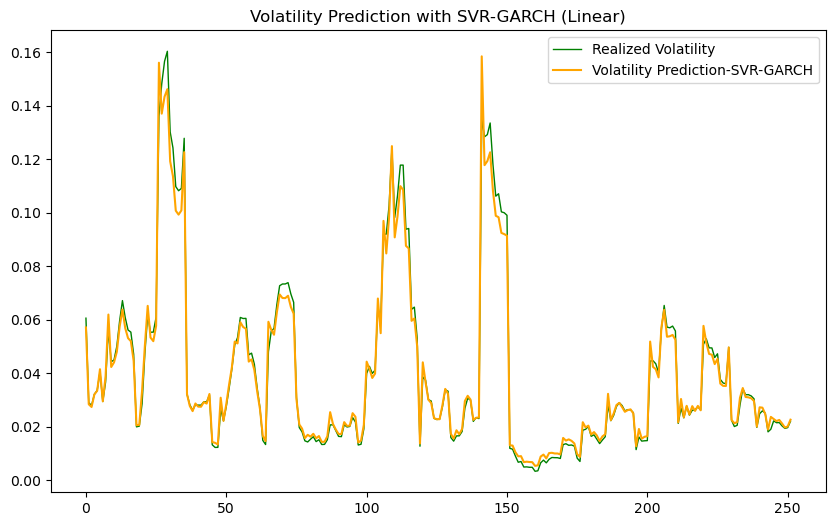

In [86]:
svr_poly = SVR(kernel='linear', C=1.0, cache_size=200, coef0=0.0, degree=3,
               epsilon=0.1, gamma='scale', max_iter=-1, shrinking=True,
               tol=0.001, verbose=False)

# Fit the SVR model to your training data
svr_poly.fit(X_trainMLI, y_trainMLI)

prediction = svr_poly.predict(X_testMLI)

plt.figure(figsize=(10, 6))
plt.plot(y_testMLI / 100, label='Realized Volatility', color='green', linewidth=1)
plt.plot(prediction / 100, label='Volatility Prediction-SVR-GARCH', color='orange')  
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

#### MPX

In [87]:
df_MPX["Return_svr"] = df_MPX["Return"]**2
X_trainMPX = df_MPX[["Return_svr","Variance"]].iloc[:-n].values
y_trainMPX = df_MPX["Variance"].iloc[2:-(n-2)].values.reshape(-1,1)
X_testMPX = df_MPX[["Return_svr","Variance"]].iloc[-n:].values
y_testMPX = df_MPX["Variance"].iloc[-n:].values.reshape(-1,1)

# Define SVR models
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

models = [svr_poly, svr_lin, svr_rbf]

# Define parameter grid
param_grid = {'gamma': [0.001, 0.01, 0.1, 1],  
              'C': [0.001, 0.01, 0.1, 1],      
              'epsilon': [0.001, 0.01, 0.1, 1]}  

best_models = []
kf = KFold(n_splits=3, shuffle=False)  
for model in models:
    clf = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, cv=kf, random_state=42, n_jobs=-1)
    clf.fit(X_trainMPX, y_trainMPX)
    best_models.append(clf.best_estimator_)

# Predict using each best model
predictions = [model.predict(X_testMPX) for model in best_models]

# Calculate RMSE for each prediction
rmses = [np.sqrt(mean_squared_error(y_testMPX / 100, prediction / 100)) for prediction in predictions]

# Print RMSE for each model
for i, model in enumerate(models):
    print(f'The RMSE value of SVR with {model.kernel} Parameters {model.get_params()} Kernel is {rmses[i]:.6f}')
    print("\n" + "-" * 50 + "\n")

The RMSE value of SVR with poly Parameters {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False} Kernel is 0.045048

--------------------------------------------------

The RMSE value of SVR with linear Parameters {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False} Kernel is 0.008194

--------------------------------------------------

The RMSE value of SVR with rbf Parameters {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False} Kernel is 0.017670

--------------------------------------------------



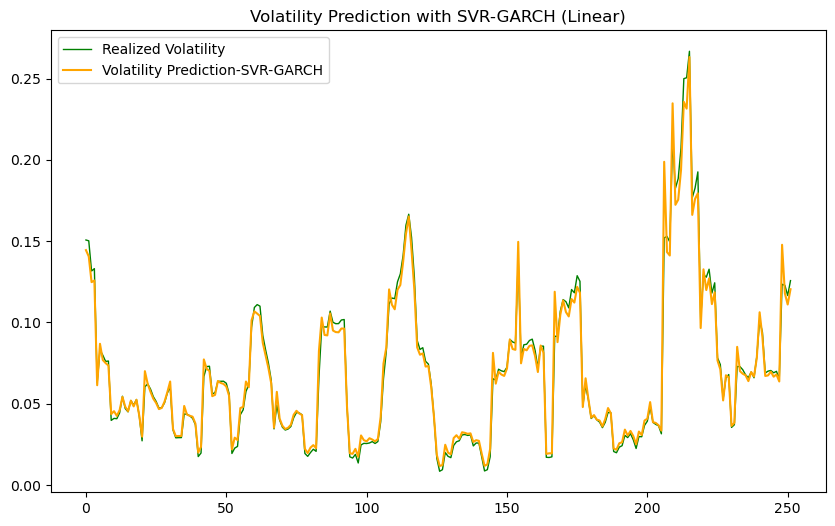

In [88]:
svr_poly = SVR(kernel='linear', C=1.0, cache_size=200, coef0=0.0, degree=3,
               epsilon=0.1, gamma='scale', max_iter=-1, shrinking=True,
               tol=0.001, verbose=False)

# Fit the SVR model to your training data
svr_poly.fit(X_trainMPX, y_trainMPX)

# Make predictions on the test data
prediction = svr_poly.predict(X_testMPX)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_testMPX / 100, label='Realized Volatility', color='green', linewidth=1)
plt.plot(prediction / 100, label='Volatility Prediction-SVR-GARCH', color='orange')  
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

### NN

#### MED

The RMSE value of NN is 0.009626


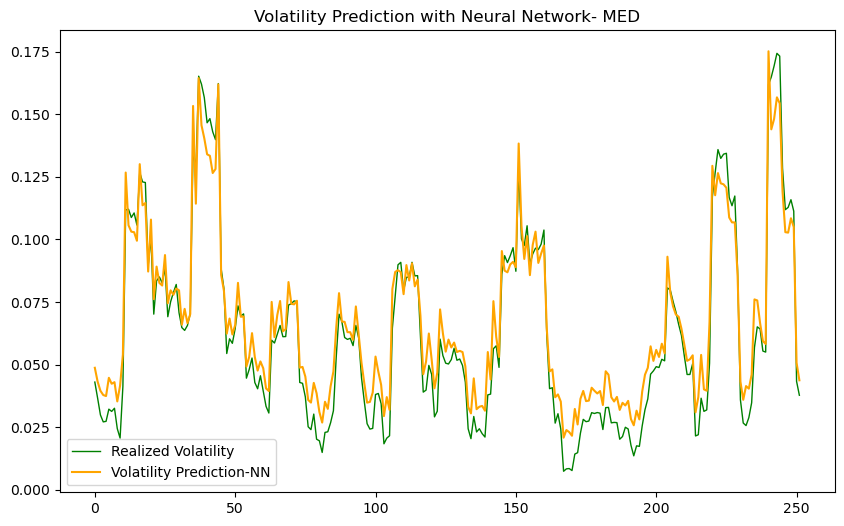

In [89]:
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1) 
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
               'max_iter': [500, 1000],
               'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X_trainMED, y_trainMED)
NN_predictions = clf.predict(X_testMED)
rmse_NN = np.sqrt(mean_squared_error(y_testMED / 100, NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

plt.figure(figsize=(10, 6))
plt.plot(y_testMED / 100, label='Realized Volatility', color='green', linewidth=1)
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN', color='orange')  
plt.title('Volatility Prediction with Neural Network- MED', fontsize=12)
plt.legend()
plt.show()

#### MLI

The RMSE value of NN is 0.008089


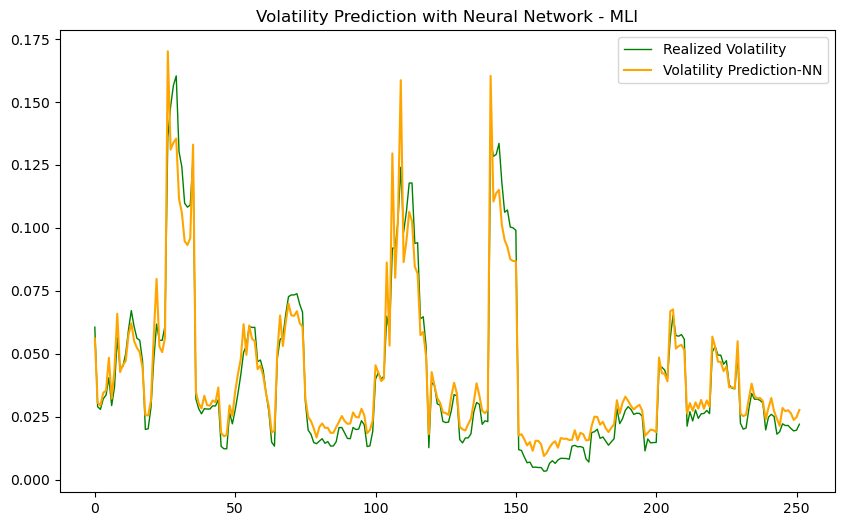

In [90]:
clf.fit(X_trainMLI, y_trainMLI)
NN_predictions = clf.predict(X_testMLI)
rmse_NN = np.sqrt(mean_squared_error(y_testMLI / 100, NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

plt.figure(figsize=(10, 6))
plt.plot(y_testMLI / 100, label='Realized Volatility', color='green', linewidth=1)
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN', color='orange')  
plt.title('Volatility Prediction with Neural Network - MLI', fontsize=12)
plt.legend()
plt.show()

#### MPX

The RMSE value of NN is 0.017448


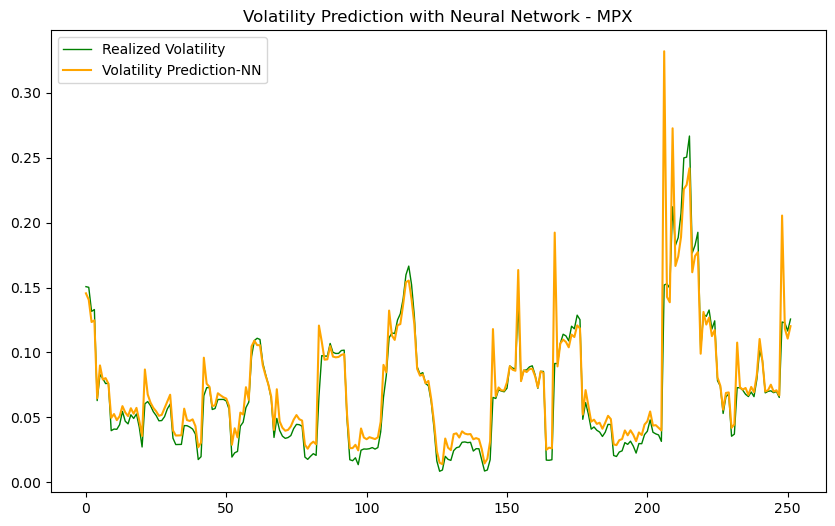

In [91]:
clf.fit(X_trainMPX, y_trainMPX)
NN_predictions = clf.predict(X_testMPX)
rmse_NN = np.sqrt(mean_squared_error(y_testMPX / 100, NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

plt.figure(figsize=(10, 6))
plt.plot(y_testMPX / 100, label='Realized Volatility', color='green', linewidth=1)
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN', color='orange')  
plt.title('Volatility Prediction with Neural Network - MPX', fontsize=12)
plt.legend()
plt.show()

### Step Three: Pair Trading with Volatility clustering

In [92]:
start, end = dt.datetime(2022, 1, 1), dt.datetime(2023, 12, 30)
StockList = ['MED', 'MPX','MLI']
price = pd.DataFrame()
for ticker in StockList:
    price[ticker]  = pdr.get_data_yahoo(ticker, start=start, end=end).loc[:,'Adj Close'] 

price.dropna(inplace=True)
data = price.copy()
df = data.copy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Before starting the trading strategy, I run a cointegration test on stocks. If they are co-integrated the strategy will be more profitable than if they are not.

In [93]:
import itertools as it
from itertools import combinations
symbPairs = list(combinations(StockList, 2))

In [94]:
# set the trainlen length at 125 samples for Johansen test and the lookback at 10 days for the portfolio price
# Z-variable

trainlen=250//2
lookback=16//2


for t in range(trainlen+1, df.shape[0]):
    # Johansen test
    result=vm.coint_johansen(df.values[(t-trainlen-1):t-1], det_order=0, k_ar_diff=1)

In [96]:
# Extract the trace statistics and eigen statistics
eigenvalues = result.evec
trace_stats = result.lr1
eigen_stats = result.lr2

# Print the test results
print("Johansen Cointegration Test Results (Testing for Zero Cointegrating Relationships):")
print(f"Eigenvalues:{result.evec}")
print(f"Trace Statistics: {result.lr1}")
print(f"Critical Values: {result.cvt}")

# Define stock pairs
stock_pairs = [('MED', 'MLI'), ('MED', 'MPX'), ('MPX', 'MLI')]

# Separate the output sections
print("\n" + "-" * 50 + "\n")

# Interpret the results for each pair
for i, (stock1, stock2) in enumerate(stock_pairs):
    trace_statistic = trace_stats[i]
    eigen_statistic = eigen_stats[i]
    print(f"Pair {i + 1} ({stock1} and {stock2}):")
    print(f"Trace Statistic: {trace_statistic}")
    print(f"Eigen Statistic: {eigen_statistic}")
    print("\n" + "-" * 50 + "\n")


Johansen Cointegration Test Results (Testing for Zero Cointegrating Relationships):
Eigenvalues:[[ 0.14286713  0.12996788  0.11084533]
 [-0.26079885 -0.49020737 -0.71124311]
 [-0.20371586  0.21123469 -0.20180683]]
Trace Statistics: [20.72872085 10.18159362  3.82268205]
Critical Values: [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

--------------------------------------------------

Pair 1 (MED and MLI):
Trace Statistic: 20.728720845602382
Eigen Statistic: 10.547127226226506

--------------------------------------------------

Pair 2 (MED and MPX):
Trace Statistic: 10.181593619375876
Eigen Statistic: 6.358911569669681

--------------------------------------------------

Pair 3 (MPX and MLI):
Trace Statistic: 3.8226820497061955
Eigen Statistic: 3.8226820497061955

--------------------------------------------------



All eigenvalues are not zero, the matrix contain negative values, it would imply that a linear combination if the component series can be created, which would result in a stationary portfolio.
- Pair 1 (MED and MLI) has a trace statistic exceeding the critical values at all significance levels, indicating evidence against the null hypothesis of no cointegrating relationship.
- Pair 2 (MED and MPX) has a trace statistic exceeding the critical values at higher significance levels, suggesting evidence against the null hypothesis.
- Pair 3 (MPX and MLI) does not have a trace statistic exceeding the critical values, indicating insufficient evidence to reject the null hypothesis.


In [97]:
hedgeRatio=np.full(df.shape, np.NaN)
numUnits=np.full(df.shape[0], np.NaN)
yport_sigma_arr = np.full(df.shape[0], np.NaN)
portfolio_value = np.full(df.shape[0], np.NaN)

for t in range(trainlen+1, df.shape[0]):
    # Johansen test
    result=vm.coint_johansen(df.values[(t-trainlen-1):t-1], det_order=0, k_ar_diff=1)
    hedgeRatio[t,:]=result.evec[:, 0]
    yport=pd.DataFrame(np.dot(df.values[(t-lookback):t], result.evec[:, 0])) 
    portfolio_value[t] = yport.mean()  #  (net) market value of portfolio
    yport_sigma_arr[t] = yport.std().values[0]   # the realized volatility of the spread yport with a lookback of 10 
    
df["portfolio_value"] = portfolio_value
df["yport_sigma_arr"] = yport_sigma_arr    
df.dropna(inplace=True)
df.shape

(375, 5)

In [98]:
df.head(3)

,MED,MPX,MLI,portfolio_value,yport_sigma_arr
Date,,,,,
2022-07-06,169.321655,8.186967,25.241447,24.624196,0.305229
2022-07-07,167.731827,8.344052,26.107481,25.220541,0.304760
2022-07-08,162.006592,8.399496,25.820429,25.457082,0.300673


In [99]:
df["Return"] = 100*(df["portfolio_value"].pct_change())
df["Return_svm"] = df["Return"]**2

In [100]:
df.dropna(inplace = True)

In [101]:
df.head(3)

,MED,MPX,MLI,portfolio_value,yport_sigma_arr,Return,Return_svm
Date,,,,,,,
2022-07-07,167.731827,8.344052,26.107481,25.220541,0.304760,2.421785,5.865041
2022-07-08,162.006592,8.399496,25.820429,25.457082,0.300673,0.937890,0.879637
2022-07-11,162.695831,8.140766,25.747444,26.374623,0.285610,3.604266,12.990734


In [102]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df.head(3)

,MED,MPX,MLI,portfolio_value,yport_sigma_arr,Return,Return_svm
0,3.206880,-1.514589,-2.042836,0.850450,-0.732692,0.092482,-0.084050
1,2.945330,-1.491788,-2.105324,0.866196,-0.744365,0.083985,-0.084064
2,2.976817,-1.598188,-2.121212,0.927275,-0.787382,0.099253,-0.084031


In [103]:
n = 100
X_train = scaled_df[[ 'portfolio_value','yport_sigma_arr', 'Return_svm']].iloc[:-n].values
y_train = scaled_df['yport_sigma_arr'].iloc[2:-(n-2)].values.reshape(-1,1) # shifted by 2 time steps to align with the features.
X_test = scaled_df[[ 'portfolio_value', 'yport_sigma_arr',  'Return_svm']].iloc[-n:].values
y_test = scaled_df['yport_sigma_arr'].iloc[-n:].values.reshape(-1,1)

The RMSE value 0.002509


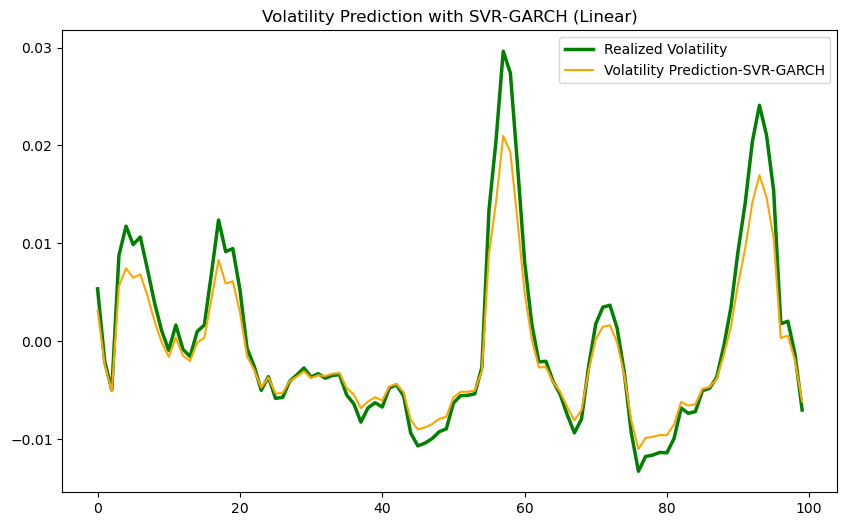

In [104]:
svr_linear = SVR(kernel='linear', C=1.0, cache_size=200, coef0=0.0, degree=3,
               epsilon=0.1, gamma='scale', max_iter=-1, shrinking=True,
               tol=0.001, verbose=False)

# Fit the SVR model to your training data
svr_linear.fit(X_train, y_train)

# Make predictions on the test data
prediction = svr_linear.predict(X_test)

#Calculate RMSE for each prediction
rmses = np.sqrt(mean_squared_error(y_test / 100, prediction / 100)) 
print(f'The RMSE value {rmses:.6f}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test / 100, label='Realized Volatility', color='green', linewidth=2.5)
plt.plot(prediction / 100, label='Volatility Prediction-SVR-GARCH', color='orange')  
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

APR=0.434092 Sharpe=1.658975


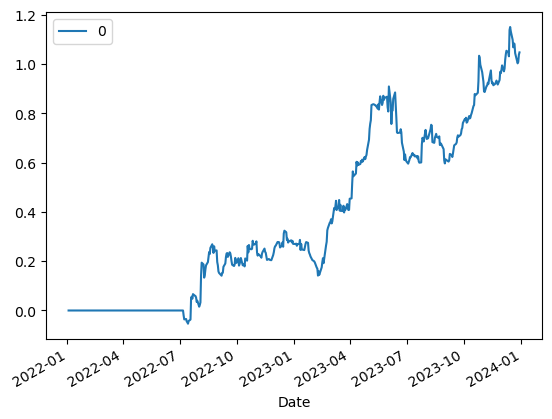

In [105]:
signal_list = []
signal = 1  
for t in range(trainlen+1, data.shape[0]):
    # Johansen test
    result=vm.coint_johansen(data.values[(t-trainlen-1):t-1], det_order=0, k_ar_diff=1)
    hedgeRatio[t,:]=result.evec[:, 0]
    yport=pd.DataFrame(np.dot(data.values[(t-lookback):t], result.evec[:, 0]))
    yport_sigma_arr[t] = yport.std().values[0]
    try:
        
        if (prediction[t]>yport_sigma_arr[t]):
            signal = -1 #if volatility is increasing reverse the trading signal setting it to -1
        else:
            signal = 1 #otherwise let it be the same
    except:
        signal = 1
    signal_list.append(signal)
    ma=yport.mean()
    mstd=yport.std()
    numUnits[t]=signal*-(yport.iloc[-1,:]-ma)/mstd 
    


positions=pd.DataFrame(np.expand_dims(numUnits, axis=1)*hedgeRatio)*data.values 
pnl=np.sum((positions.shift().values)*(data.pct_change().values), axis=1)
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
ret.fillna(value=0, inplace=True)
equity_df = pd.DataFrame((np.cumprod(1+ret)-1).values, index=data.index)
equity_df.plot()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))

In [106]:
portfolio_value = positions.sum(axis=1)
WRC_data = pd.DataFrame()
WRC_data["portfolio_value"] = portfolio_value
WRC_data["num_units"] = signal

In [107]:
def detrendPrice(series):
    # fit linear model
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    result = model.fit()
    #y = pd.Series(y)
    #intercept = result.params[0]
    #beta = result.params[1]
    #print(result.summary())
    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    #the residuals are the detrended prices
    resid = y-y_hat
    #add minimum necessary to residuals to avoid negative detrended prices
    resid = resid + abs(resid.min() + 1/10*resid.min())
    return resid 

In [108]:
def bootstrap(ser):
    ser.dropna(inplace=True)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    #ave = ms.gmean(arr) #geometric mean

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean
    #mb = ms.gmean(mb, axis=0) #geometric mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5])) 
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break
        
    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)
    return p

In [109]:
WRC_data['Det_PV'] = detrendPrice(WRC_data['portfolio_value']).values
WRC_data['Det_pct_PV'] = (WRC_data['Det_PV']-WRC_data['Det_PV'].shift(1))/abs(WRC_data['Det_PV'].shift(1)) 
WRC_data['Det_port_rets'] = WRC_data['Det_pct_PV'] * WRC_data['num_units'].shift(1) 
bootstrap(WRC_data['Det_port_rets'])

average return 0.033275
[-0.02488476  0.02704798]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)


0.007600000000000051